In [1]:
from stardist import random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist
lbl_cmap = random_label_cmap()
from stardist.matching import matching_dataset
from stardist.models import StarDist2D, Config2D
import cv2
import os
from glob import glob
from tqdm import tqdm
import multiprocessing as mp
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import ImportImg
import numpy as np

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

Using TensorFlow backend.


In [2]:
MasterPath_MdlTraining = os.path.abspath("//fs9.nus.edu.sg/bie/MBELab/jokhun/Pro 1/U2OS small mol screening/StarDist_Segmentation/")

X_Train_Paths = sorted(glob(os.path.join(MasterPath_MdlTraining,'Raw_GrndTrth_ImgPairs',"x_*.tif")))
Y_Train_Paths = sorted(glob(os.path.join(MasterPath_MdlTraining,'Raw_GrndTrth_ImgPairs',"y_*.tif")))

print('No. of raw training paths : ',str(len(X_Train_Paths)))
print('Raw training path 0 : ',str(X_Train_Paths[0]))                          
print('\nNo. of labelled training paths : ',str(len(Y_Train_Paths)))
print('Labelled training path 0 : ',str(Y_Train_Paths[0]))

No. of raw training paths :  50
Raw training path 0 :  \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\StarDist_Segmentation\Raw_GrndTrth_ImgPairs\x_cdp2bioactives_a01_s3_w1db88f12a-c079-4aee-a3ce-4d2531f7163f.tif

No. of labelled training paths :  50
Labelled training path 0 :  \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\StarDist_Segmentation\Raw_GrndTrth_ImgPairs\y_cdp2bioactives_a01_s3_w1db88f12a-c079-4aee-a3ce-4d2531f7163f.tif


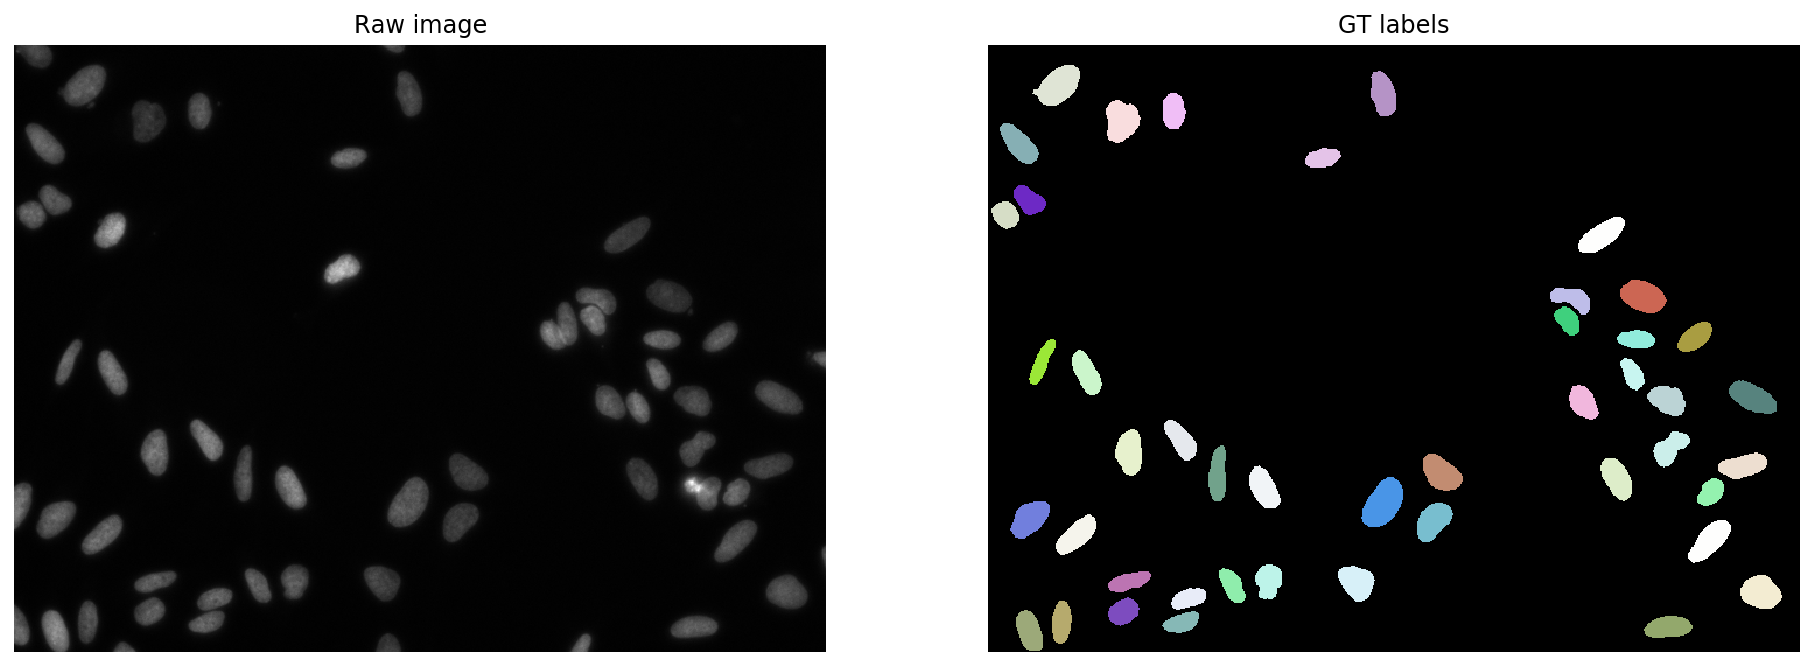

In [3]:
with mp.Pool() as pool:
    X = pool.map(ImportImg.Import_GrayImg,[path for path in X_Train_Paths])
    Y = pool.map(ImportImg.Import_Img,[path for path in Y_Train_Paths])

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

img, lbl = X[0], Y[0]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(1,2,1); plt.imshow(img,cmap='gray', norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Raw image')
plt.subplot(1,2,2); plt.imshow(lbl,cmap=lbl_cmap, norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('GT labels')
None;


In [4]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState()
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.5 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  50
- training:        25
- validation:      25


# StarDist

In [ ]:
Display_Eg_StarConvexPolygon_fit_on_GrndTrth = False
# Examples of fitting the labelled images (Y) with different star-convex polygons

if Display_Eg_StarConvexPolygon_fit_on_GrndTrth:
    n_rays = [2**i for i in range(2,8)]
    scores = []
    fig, ax = plt.subplots(2,3, figsize=(16,11))
    for i,r in tqdm(enumerate(n_rays)):
        Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)

        a=ax.flat[i]
        a.imshow(Y_reconstructed[0], cmap=lbl_cmap)
        a.set_title('Reconstructed (%d rays)' % r)
        a.axis('off')
    plt.tight_layout();

    plt.figure(figsize=(8,5))
    plt.plot(n_rays, scores, 'o-')
    plt.xlabel('Number of rays for star-convex polygon')
    plt.ylabel('Reconstruction score (mean intersection over union)')
    plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")


In [ ]:
Display_ConfigDoc = False
# A `StarDist2D` model is specified via a `Config2D` object.
if Display_ConfigDoc:
    print(Config2D.__doc__)

## Building/Calling the StarDist model
Note: The trained StarDist2D model will not predict completed shapes for partially visible objects at the image boundary if train_shape_completion=False (which is the default option).

In [5]:
# Create a new model, use a custom one or use pretained "StarDist2D.from_pretrained('2D_versatile_fluo')"
Model2Use = 'New' # 'New', 'Custom' or '2D_versatile_fluo'


if Model2Use=='Custom':
    load_ModelDir = os.path.abspath(
        r'\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1\U2OS small mol screening\StarDist_Segmentation'
    )
    load_ModelName = 'stardist'
    model = StarDist2D(None, name=load_ModelName, basedir=load_ModelDir)
    
    
if Model2Use=='New':
    # 32 is a good number of rays to define the shape of nuclei (see images above)
    n_rays = 32
    # Use OpenCL-based computations for data generator during training (requires 'gputools')
    use_gpu = True and gputools_available()
    # Predict on subsampled grid for increased efficiency and larger field of view
    grid = (2,2)
    conf = Config2D (
        n_rays       = n_rays,
        grid         = grid,
        use_gpu      = use_gpu,
        n_channel_in = n_channel,
    )
    if use_gpu:
        from csbdeep.utils.tf import limit_gpu_memory
        # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
        limit_gpu_memory(0.8)
    print(conf,'\n')
    [print(key, ':', value) for key, value in vars(conf).items()]
    model = StarDist2D(conf, name='stardist', basedir=MasterPath_MdlTraining)
    print('New model saved at : '+str(os.path.join(MasterPath_MdlTraining,'stardist')))

    
if Model2Use=='2D_versatile_fluo':
    print('\nLoading pretrained 2D_versatile_fluo model!')
    model = StarDist2D.from_pretrained('2D_versatile_fluo')

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False) 

n_dim : 2
axes : YXC
n_channel_in : 1
n_channel_out 

In [6]:
# Check if the neural network has a large enough field of view to see up to the boundary of most objects.
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

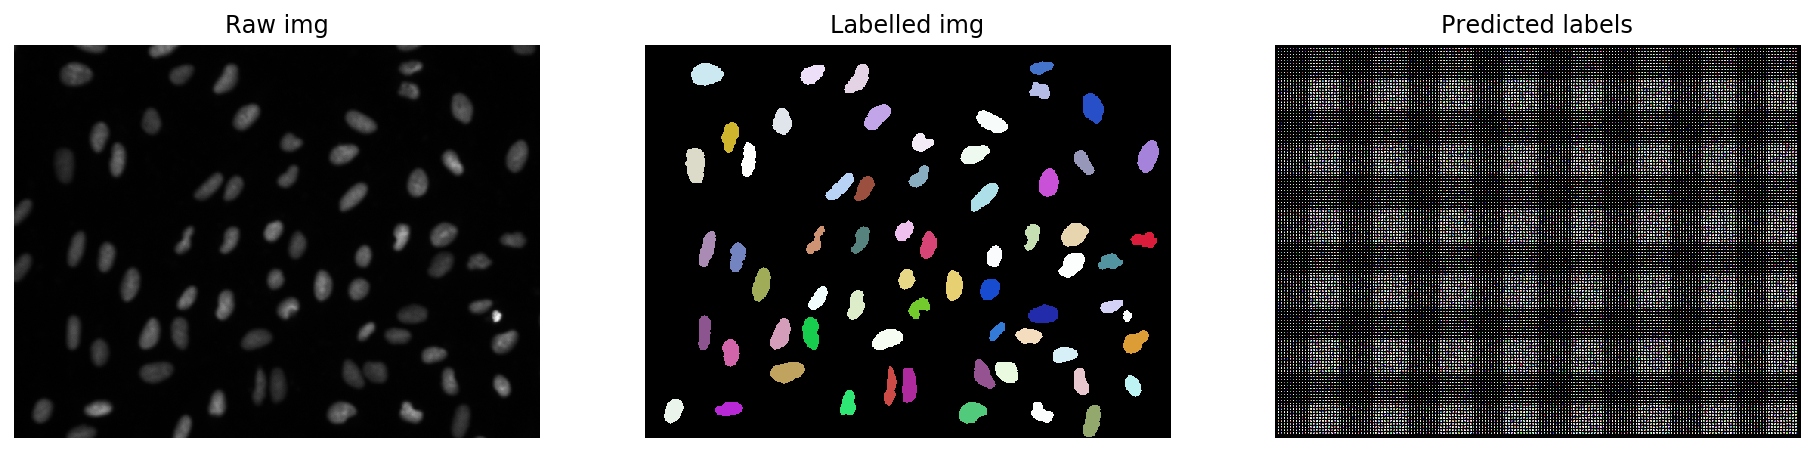

In [7]:
# Example
img=X_val[0]
lbl=Y_val[0]
pred,_ = model.predict_instances(img)

plt.figure(figsize=(16,10))
plt.subplot(1,3,1); plt.imshow(img,cmap='gray', norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Raw img')
plt.subplot(1,3,2); plt.imshow(lbl,cmap=lbl_cmap, norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Labelled img')
plt.subplot(1,3,3); plt.imshow(pred,cmap=lbl_cmap, norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Predicted labels')
plt.savefig(str(os.path.join(MasterPath_MdlTraining,'VirginModel.png')))

### Loading pretrained weights from 2D_versatile_fluo onto model

In [8]:
LoadPretrainedWeights__2D_versatile_fluo = True

if LoadPretrainedWeights__2D_versatile_fluo:

    Dir_ForSaving_PretrainedWeights = os.path.join(MasterPath_MdlTraining,'stardist','weights_2D_versatile_fluo.h5')

    # Import and save the pretrained weights in Dir_ForSaving_PretrainedWeights
    tmp = StarDist2D.from_pretrained('2D_versatile_fluo')
    tmp.keras_model.save_weights(Dir_ForSaving_PretrainedWeights)

    # Load the saved pretrained weights onto the current model
    model.load_weights(Dir_ForSaving_PretrainedWeights)
    # Load the pretrained thresholds onto the current model
    model.thresholds={'prob':tmp.thresholds.prob, 'nms':tmp.thresholds.nms}

    print("\nWeights and thresholds loaded from '2D_versatile_fluo'!")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.

Weights and thresholds loaded from '2D_versatile_fluo'!


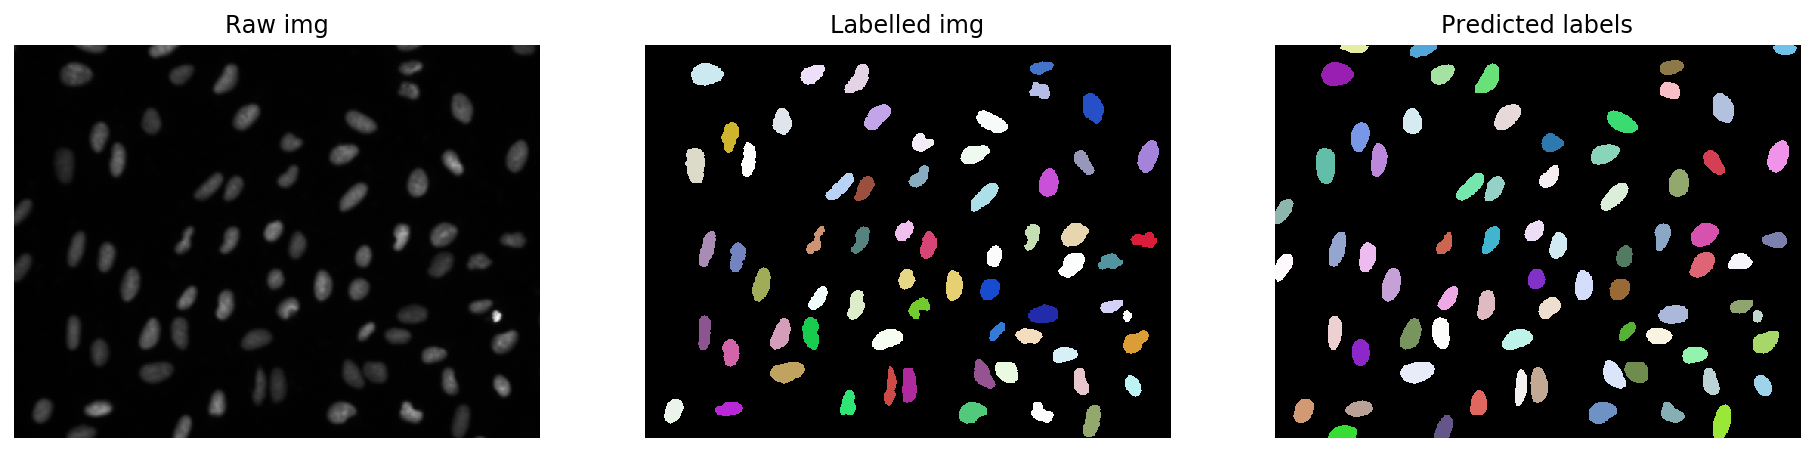

In [9]:
# Example
img=X_val[0]
lbl=Y_val[0]
pred,_ = model.predict_instances(img)

plt.figure(figsize=(16,10))
plt.subplot(1,3,1); plt.imshow(img,cmap='gray', norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Raw img')
plt.subplot(1,3,2); plt.imshow(lbl,cmap=lbl_cmap, norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Labelled img')
plt.subplot(1,3,3); plt.imshow(pred,cmap=lbl_cmap, norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Predicted labels')
plt.savefig(str(os.path.join(MasterPath_MdlTraining,'PretrainedWeights.png')))

# Training the model

### Image generator 'augmenter'
You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images:

In [10]:
def random_fliprot(img, mask): 
    axes = tuple(range(img.ndim)) 
    perm = np.random.permutation(axes)
    img = img.transpose(perm) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    return x, y

You can disable augmentation by setting `augmenter = None`.

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [11]:
TrainModel = True
if TrainModel:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), 
                epochs=10, augmenter=augmenter)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/10
 24/100 [======>.......................] - ETA: 35s - loss: 0.2127 - prob_loss: 0.0855 - dist_loss: 0.6359 - prob_kld: 0.0143 - dist_relevant_mae: 0.6416 - dist_relevant_mse: 1.1781  ETA: 1:01 - loss: 0.2252 - prob_loss: 0.0875 - dist_loss: 0.6887 - prob_kld: 0.0149 - dist_relevant_mae: 0.6826 - dist_rele

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/100 [======>.......................] - ETA: 34s - loss: 0.2134 - prob_loss: 0.0864 - dist_loss: 0.6351 - prob_kld: 0.0142 - dist_relevant_mae: 0.6405 - dist_relevant_mse: 1.1671

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/100 [======>.......................] - ETA: 34s - loss: 0.2135 - prob_loss: 0.0865 - dist_loss: 0.6349 - prob_kld: 0.0143 - dist_relevant_mae: 0.6400 - dist_relevant_mse: 1.1615

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/100 [========>.....................] - ETA: 31s - loss: 0.2138 - prob_loss: 0.0849 - dist_loss: 0.6443 - prob_kld: 0.0133 - dist_relevant_mae: 0.6494 - dist_relevant_mse: 1.2666

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/100 [========>.....................] - ETA: 30s - loss: 0.2129 - prob_loss: 0.0844 - dist_loss: 0.6422 - prob_kld: 0.0131 - dist_relevant_mae: 0.6469 - dist_relevant_mse: 1.2581

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/100 [=========>....................] - ETA: 28s - loss: 0.2131 - prob_loss: 0.0855 - dist_loss: 0.6380 - prob_kld: 0.0136 - dist_relevant_mae: 0.6432 - dist_relevant_mse: 1.2333

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/100 [==================>...........] - ETA: 14s - loss: 0.2066 - prob_loss: 0.0837 - dist_loss: 0.6145 - prob_kld: 0.0129 - dist_relevant_mae: 0.6168 - dist_relevant_mse: 1.1867

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/100 [====================>.........] - ETA: 11s - loss: 0.2060 - prob_loss: 0.0840 - dist_loss: 0.6099 - prob_kld: 0.0131 - dist_relevant_mae: 0.6119 - dist_relevant_mse: 1.1629

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/100 [====================>.........] - ETA: 10s - loss: 0.2057 - prob_loss: 0.0838 - dist_loss: 0.6099 - prob_kld: 0.0130 - dist_relevant_mae: 0.6119 - dist_relevant_mse: 1.169

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/100 [====================>.........] - ETA: 10s - loss: 0.2052 - prob_loss: 0.0836 - dist_loss: 0.6082 - prob_kld: 0.0130 - dist_relevant_mae: 0.6100 - dist_relevant_mse: 1.1600

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/100 [=====================>........] - ETA: 10s - loss: 0.2050 - prob_loss: 0.0835 - dist_loss: 0.6076 - prob_kld: 0.0129 - dist_relevant_mae: 0.6093 - dist_relevant_mse: 1.158

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/100 [=====================>........] - ETA: 9s - loss: 0.2050 - prob_loss: 0.0836 - dist_loss: 0.6071 - prob_kld: 0.0129 - dist_relevant_mae: 0.6087 - dist_relevant_mse: 1.157

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/100 [======================>.......] - ETA: 8s - loss: 0.2041 - prob_loss: 0.0829 - dist_loss: 0.6059 - prob_kld: 0.0128 - dist_relevant_mae: 0.6077 - dist_relevant_mse: 1.1531

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/100 [======================>.......] - ETA: 8s - loss: 0.2041 - prob_loss: 0.0829 - dist_loss: 0.6060 - prob_kld: 0.0128 - dist_relevant_mae: 0.6078 - dist_relevant_mse: 1.1532

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/100 [=======================>......] - ETA: 7s - loss: 0.2036 - prob_loss: 0.0829 - dist_loss: 0.6038 - prob_kld: 0.0129 - dist_relevant_mae: 0.6052 - dist_relevant_mse: 1.1382

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/100 [========================>.....] - ETA: 6s - loss: 0.2033 - prob_loss: 0.0832 - dist_loss: 0.6005 - prob_kld: 0.0128 - dist_relevant_mae: 0.6024 - dist_relevant_mse: 1.1259

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/100 [========================>.....] - ETA: 5s - loss: 0.2033 - prob_loss: 0.0833 - dist_loss: 0.6001 - prob_kld: 0.0129 - dist_relevant_mae: 0.6019 - dist_relevant_mse: 1.1232

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/100 [=========================>....] - ETA: 4s - loss: 0.2025 - prob_loss: 0.0828 - dist_loss: 0.5983 - prob_kld: 0.0127 - dist_relevant_mae: 0.5997 - dist_relevant_mse: 1.11

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/100 [==========================>...] - ETA: 3s - loss: 0.2028 - prob_loss: 0.0833 - dist_loss: 0.5975 - prob_kld: 0.0127 - dist_relevant_mae: 0.5984 - dist_relevant_mse: 1.1079

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/100 [==========================>...] - ETA: 2s - loss: 0.2026 - prob_loss: 0.0834 - dist_loss: 0.5961 - prob_kld: 0.0129 - dist_relevant_mae: 0.5968 - dist_relevant_mse: 1.0983

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/100 [===========================>..] - ETA: 2s - loss: 0.2023 - prob_loss: 0.0831 - dist_loss: 0.5958 - prob_kld: 0.0129 - dist_relevant_mae: 0.5965 - dist_relevant_mse: 1.0961

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 39s 391ms/step - loss: 0.2011 - prob_loss: 0.0826 - dist_loss: 0.5922 - prob_kld: 0.0126 - dist_relevant_mae: 0.5932 - dist_relevant_mse: 1.0858 - val_loss: 0.1964 - val_prob_loss: 0.0864 - val_dist_loss: 0.5294 - val_prob_kld: 0.0122 - val_dist_relevant_mae: 0.5356 - val_dist_relevant_mse: 0.8742

Epoch 2/10
 15/100 [===>..........................] - ETA: 23s - loss: 0.1918 - prob_loss: 0.0823 - dist_loss: 0.5477 - prob_kld: 0.0108 - dist_relevant_mae: 0.5455 - dist_relevant_mse: 0.9169

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/100 [=====>........................] - ETA: 23s - loss: 0.1959 - prob_loss: 0.0857 - dist_loss: 0.5509 - prob_kld: 0.0121 - dist_relevant_mae: 0.5460 - dist_relevant_mse: 0.9218

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/100 [=====>........................] - ETA: 22s - loss: 0.1936 - prob_loss: 0.0840 - dist_loss: 0.5481 - prob_kld: 0.0117 - dist_relevant_mae: 0.5434 - dist_relevant_mse: 0.920

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/100 [======>.......................] - ETA: 21s - loss: 0.1953 - prob_loss: 0.0860 - dist_loss: 0.5463 - prob_kld: 0.0118 - dist_relevant_mae: 0.5415 - dist_relevant_mse: 0.9057

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/100 [========>.....................] - ETA: 20s - loss: 0.1953 - prob_loss: 0.0862 - dist_loss: 0.5452 - prob_kld: 0.0122 - dist_relevant_mae: 0.5419 - dist_relevant_mse: 0.9260

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/100 [========>.....................] - ETA: 20s - loss: 0.1946 - prob_loss: 0.0860 - dist_loss: 0.5430 - prob_kld: 0.0119 - dist_relevant_mae: 0.5397 - dist_relevant_mse: 0.9099

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/100 [=========>....................] - ETA: 20s - loss: 0.1951 - prob_loss: 0.0870 - dist_loss: 0.5405 - prob_kld: 0.0121 - dist_relevant_mae: 0.5372 - dist_relevant_mse: 0.8882

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/100 [==========>...................] - ETA: 19s - loss: 0.1947 - prob_loss: 0.0865 - dist_loss: 0.5409 - prob_kld: 0.0119 - dist_relevant_mae: 0.5377 - dist_relevant_mse: 0.9036

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/100 [===========>..................] - ETA: 18s - loss: 0.1940 - prob_loss: 0.0855 - dist_loss: 0.5423 - prob_kld: 0.0120 - dist_relevant_mae: 0.5388 - dist_relevant_mse: 0.9050

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/100 [==============>...............] - ETA: 15s - loss: 0.1940 - prob_loss: 0.0852 - dist_loss: 0.5439 - prob_kld: 0.0117 - dist_relevant_mae: 0.5394 - dist_relevant_mse: 0.8999

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/100 [===============>..............] - ETA: 14s - loss: 0.1940 - prob_loss: 0.0852 - dist_loss: 0.5438 - prob_kld: 0.0116 - dist_relevant_mae: 0.5395 - dist_relevant_mse: 0.8966

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/100 [================>.............] - ETA: 13s - loss: 0.1945 - prob_loss: 0.0856 - dist_loss: 0.5446 - prob_kld: 0.0116 - dist_relevant_mae: 0.5407 - dist_relevant_mse: 0.8985

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/100 [=================>............] - ETA: 12s - loss: 0.1940 - prob_loss: 0.0853 - dist_loss: 0.5435 - prob_kld: 0.0117 - dist_relevant_mae: 0.5399 - dist_relevant_mse: 0.8924

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/100 [=================>............] - ETA: 12s - loss: 0.1936 - prob_loss: 0.0850 - dist_loss: 0.5431 - prob_kld: 0.0118 - dist_relevant_mae: 0.5395 - dist_relevant_mse: 0.8870

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/100 [======================>.......] - ETA: 6s - loss: 0.1921 - prob_loss: 0.0841 - dist_loss: 0.5398 - prob_kld: 0.0118 - dist_relevant_mae: 0.5371 - dist_relevant_mse: 0.8867

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/100 [=======================>......] - ETA: 5s - loss: 0.1925 - prob_loss: 0.0842 - dist_loss: 0.5417 - prob_kld: 0.0118 - dist_relevant_mae: 0.5392 - dist_relevant_mse: 0.9001

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/100 [========================>.....] - ETA: 4s - loss: 0.1917 - prob_loss: 0.0836 - dist_loss: 0.5404 - prob_kld: 0.0117 - dist_relevant_mae: 0.5378 - dist_relevant_mse: 0.8928

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/100 [===========================>..] - ETA: 1s - loss: 0.1910 - prob_loss: 0.0834 - dist_loss: 0.5384 - prob_kld: 0.0117 - dist_relevant_mae: 0.5364 - dist_relevant_mse: 0.8865

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/100 [============================>.] - ETA: 0s - loss: 0.1909 - prob_loss: 0.0833 - dist_loss: 0.5379 - prob_kld: 0.0116 - dist_relevant_mae: 0.5359 - dist_relevant_mse: 0.8812

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 34s 341ms/step - loss: 0.1910 - prob_loss: 0.0835 - dist_loss: 0.5375 - prob_kld: 0.0117 - dist_relevant_mae: 0.5355 - dist_relevant_mse: 0.8784 - val_loss: 0.1935 - val_prob_loss: 0.0857 - val_dist_loss: 0.5196 - val_prob_kld: 0.0114 - val_dist_relevant_mae: 0.5248 - val_dist_relevant_mse: 0.8490
Epoch 3/10
 21/100 [=====>........................] - ETA: 23s - loss: 0.1853 - prob_loss: 0.0770 - dist_loss: 0.5414 - prob_kld: 0.0101 - dist_relevant_mae: 0.5439 - dist_relevant_mse: 0.8359

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/100 [=====>........................] - ETA: 23s - loss: 0.1848 - prob_loss: 0.0765 - dist_loss: 0.5415 - prob_kld: 0.0103 - dist_relevant_mae: 0.5439 - dist_relevant_mse: 0.8305

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/100 [======>.......................] - ETA: 23s - loss: 0.1848 - prob_loss: 0.0765 - dist_loss: 0.5413 - prob_kld: 0.0101 - dist_relevant_mae: 0.5434 - dist_relevant_mse: 0.8234

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/100 [==========>...................] - ETA: 20s - loss: 0.1865 - prob_loss: 0.0779 - dist_loss: 0.5426 - prob_kld: 0.0100 - dist_relevant_mae: 0.5436 - dist_relevant_mse: 0.868

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/100 [===========>..................] - ETA: 18s - loss: 0.1878 - prob_loss: 0.0784 - dist_loss: 0.5470 - prob_kld: 0.0098 - dist_relevant_mae: 0.5438 - dist_relevant_mse: 0.877

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/100 [===========>..................] - ETA: 18s - loss: 0.1873 - prob_loss: 0.0781 - dist_loss: 0.5462 - prob_kld: 0.0098 - dist_relevant_mae: 0.5430 - dist_relevant_mse: 0.874

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/100 [============>.................] - ETA: 18s - loss: 0.1878 - prob_loss: 0.0787 - dist_loss: 0.5455 - prob_kld: 0.0099 - dist_relevant_mae: 0.5423 - dist_relevant_mse: 0.8693

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/100 [=============>................] - ETA: 17s - loss: 0.1875 - prob_loss: 0.0784 - dist_loss: 0.5451 - prob_kld: 0.0099 - dist_relevant_mae: 0.5420 - dist_relevant_mse: 0.8674

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/100 [==============>...............] - ETA: 16s - loss: 0.1875 - prob_loss: 0.0785 - dist_loss: 0.5450 - prob_kld: 0.0099 - dist_relevant_mae: 0.5426 - dist_relevant_mse: 0.8935

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/100 [==============>...............] - ETA: 15s - loss: 0.1873 - prob_loss: 0.0787 - dist_loss: 0.5432 - prob_kld: 0.0102 - dist_relevant_mae: 0.5407 - dist_relevant_mse: 0.8840

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/100 [================>.............] - ETA: 13s - loss: 0.1864 - prob_loss: 0.0787 - dist_loss: 0.5386 - prob_kld: 0.0100 - dist_relevant_mae: 0.5363 - dist_relevant_mse: 0.8614

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/100 [=================>............] - ETA: 13s - loss: 0.1866 - prob_loss: 0.0789 - dist_loss: 0.5384 - prob_kld: 0.0100 - dist_relevant_mae: 0.5361 - dist_relevant_mse: 0.8595

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/100 [==================>...........] - ETA: 11s - loss: 0.1862 - prob_loss: 0.0789 - dist_loss: 0.5366 - prob_kld: 0.0100 - dist_relevant_mae: 0.5348 - dist_relevant_mse: 0.8690

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/100 [====================>.........] - ETA: 10s - loss: 0.1853 - prob_loss: 0.0783 - dist_loss: 0.5352 - prob_kld: 0.0099 - dist_relevant_mae: 0.5333 - dist_relevant_mse: 0.8561

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/100 [====================>.........] - ETA: 9s - loss: 0.1860 - prob_loss: 0.0789 - dist_loss: 0.5358 - prob_kld: 0.0101 - dist_relevant_mae: 0.5339 - dist_relevant_mse: 0.8627

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/100 [=====================>........] - ETA: 8s - loss: 0.1853 - prob_loss: 0.0784 - dist_loss: 0.5348 - prob_kld: 0.0100 - dist_relevant_mae: 0.5328 - dist_relevant_mse: 0.8572

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/100 [=======================>......] - ETA: 6s - loss: 0.1858 - prob_loss: 0.0791 - dist_loss: 0.5335 - prob_kld: 0.0102 - dist_relevant_mae: 0.5314 - dist_relevant_mse: 0.8462

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/100 [=======================>......] - ETA: 5s - loss: 0.1860 - prob_loss: 0.0792 - dist_loss: 0.5340 - prob_kld: 0.0102 - dist_relevant_mae: 0.5320 - dist_relevant_mse: 0.8548

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/100 [==========================>...] - ETA: 3s - loss: 0.1873 - prob_loss: 0.0802 - dist_loss: 0.5356 - prob_kld: 0.0103 - dist_relevant_mae: 0.5337 - dist_relevant_mse: 0.8643

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/100 [============================>.] - ETA: 1s - loss: 0.1867 - prob_loss: 0.0796 - dist_loss: 0.5356 - prob_kld: 0.0103 - dist_relevant_mae: 0.5345 - dist_relevant_mse: 0.8709

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/100 [============================>.] - ETA: 0s - loss: 0.1868 - prob_loss: 0.0797 - dist_loss: 0.5355 - prob_kld: 0.0103 - dist_relevant_mae: 0.5344 - dist_relevant_mse: 0.8694

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 34s 341ms/step - loss: 0.1866 - prob_loss: 0.0793 - dist_loss: 0.5366 - prob_kld: 0.0102 - dist_relevant_mae: 0.5356 - dist_relevant_mse: 0.8693 - val_loss: 0.1972 - val_prob_loss: 0.0857 - val_dist_loss: 0.5367 - val_prob_kld: 0.0113 - val_dist_relevant_mae: 0.5437 - val_dist_relevant_mse: 0.8835
Epoch 4/10
  2/100 [..............................] - ETA: 26s - loss: 0.2002 - prob_loss: 0.0891 - dist_loss: 0.5555 - prob_kld: 0.0112 - dist_relevant_mae: 0.5552 - dist_relevant_mse: 0.827

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/100 [===>..........................] - ETA: 26s - loss: 0.1859 - prob_loss: 0.0779 - dist_loss: 0.5397 - prob_kld: 0.0099 - dist_relevant_mae: 0.5459 - dist_relevant_mse: 0.9043

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/100 [=====>........................] - ETA: 25s - loss: 0.1863 - prob_loss: 0.0789 - dist_loss: 0.5372 - prob_kld: 0.0102 - dist_relevant_mae: 0.5414 - dist_relevant_mse: 0.8978

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/100 [======>.......................] - ETA: 25s - loss: 0.1872 - prob_loss: 0.0803 - dist_loss: 0.5345 - prob_kld: 0.0110 - dist_relevant_mae: 0.5379 - dist_relevant_mse: 0.8859

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/100 [=======>......................] - ETA: 24s - loss: 0.1895 - prob_loss: 0.0818 - dist_loss: 0.5384 - prob_kld: 0.0112 - dist_relevant_mae: 0.5408 - dist_relevant_mse: 0.9115

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/100 [==============>...............] - ETA: 16s - loss: 0.1847 - prob_loss: 0.0785 - dist_loss: 0.5311 - prob_kld: 0.0103 - dist_relevant_mae: 0.5349 - dist_relevant_mse: 0.8666

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/100 [===============>..............] - ETA: 15s - loss: 0.1842 - prob_loss: 0.0783 - dist_loss: 0.5292 - prob_kld: 0.0102 - dist_relevant_mae: 0.5326 - dist_relevant_mse: 0.8558

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/100 [================>.............] - ETA: 14s - loss: 0.1826 - prob_loss: 0.0771 - dist_loss: 0.5274 - prob_kld: 0.0102 - dist_relevant_mae: 0.5318 - dist_relevant_mse: 0.8502

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 35s 349ms/step - loss: 0.1836 - prob_loss: 0.0789 - dist_loss: 0.5231 - prob_kld: 0.0101 - dist_relevant_mae: 0.5275 - dist_relevant_mse: 0.8286 - val_loss: 0.1922 - val_prob_loss: 0.0850 - val_dist_loss: 0.5159 - val_prob_kld: 0.0106 - val_dist_relevant_mae: 0.5219 - val_dist_relevant_mse: 0.8394
Epoch 5/10
 15/100 [===>..........................] - ETA: 23s - loss: 0.1853 - prob_loss: 0.0788 - dist_loss: 0.5327 - prob_kld: 0.0102 - dist_relevant_mae: 0.5264 - dist_relevant_mse: 0.8562

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/100 [===>..........................] - ETA: 23s - loss: 0.1855 - prob_loss: 0.0788 - dist_loss: 0.5336 - prob_kld: 0.0104 - dist_relevant_mae: 0.5279 - dist_relevant_mse: 0.8560

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/100 [=====>........................] - ETA: 23s - loss: 0.1846 - prob_loss: 0.0773 - dist_loss: 0.5364 - prob_kld: 0.0100 - dist_relevant_mae: 0.5346 - dist_relevant_mse: 0.8475

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/100 [=====>........................] - ETA: 23s - loss: 0.1833 - prob_loss: 0.0760 - dist_loss: 0.5362 - prob_kld: 0.0099 - dist_relevant_mae: 0.5346 - dist_relevant_mse: 0.8382

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/100 [======>.......................] - ETA: 23s - loss: 0.1857 - prob_loss: 0.0782 - dist_loss: 0.5375 - prob_kld: 0.0105 - dist_relevant_mae: 0.5362 - dist_relevant_mse: 0.8370

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/100 [=======>......................] - ETA: 22s - loss: 0.1842 - prob_loss: 0.0773 - dist_loss: 0.5348 - prob_kld: 0.0102 - dist_relevant_mae: 0.5343 - dist_relevant_mse: 0.8181

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/100 [=======>......................] - ETA: 22s - loss: 0.1855 - prob_loss: 0.0781 - dist_loss: 0.5367 - prob_kld: 0.0105 - dist_relevant_mae: 0.5364 - dist_relevant_mse: 0.834

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/100 [============>.................] - ETA: 18s - loss: 0.1842 - prob_loss: 0.0776 - dist_loss: 0.5331 - prob_kld: 0.0098 - dist_relevant_mae: 0.5326 - dist_relevant_mse: 0.8168

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/100 [============>.................] - ETA: 17s - loss: 0.1844 - prob_loss: 0.0780 - dist_loss: 0.5320 - prob_kld: 0.0097 - dist_relevant_mae: 0.5314 - dist_relevant_mse: 0.8123

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/100 [=============>................] - ETA: 16s - loss: 0.1856 - prob_loss: 0.0790 - dist_loss: 0.5327 - prob_kld: 0.0099 - dist_relevant_mae: 0.5323 - dist_relevant_mse: 0.8243

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/100 [==============>...............] - ETA: 16s - loss: 0.1858 - prob_loss: 0.0791 - dist_loss: 0.5334 - prob_kld: 0.0098 - dist_relevant_mae: 0.5331 - dist_relevant_mse: 0.8261

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/100 [==============>...............] - ETA: 16s - loss: 0.1856 - prob_loss: 0.0787 - dist_loss: 0.5346 - prob_kld: 0.0098 - dist_relevant_mae: 0.5344 - dist_relevant_mse: 0.8559

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/100 [===============>..............] - ETA: 15s - loss: 0.1854 - prob_loss: 0.0788 - dist_loss: 0.5329 - prob_kld: 0.0097 - dist_relevant_mae: 0.5330 - dist_relevant_mse: 0.8472

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/100 [==================>...........] - ETA: 11s - loss: 0.1860 - prob_loss: 0.0791 - dist_loss: 0.5345 - prob_kld: 0.0097 - dist_relevant_mae: 0.5346 - dist_relevant_mse: 0.8607

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/100 [====================>.........] - ETA: 9s - loss: 0.1867 - prob_loss: 0.0797 - dist_loss: 0.5349 - prob_kld: 0.0099 - dist_relevant_mae: 0.5351 - dist_relevant_mse: 0.8730 

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/100 [=====================>........] - ETA: 8s - loss: 0.1866 - prob_loss: 0.0793 - dist_loss: 0.5363 - prob_kld: 0.0098 - dist_relevant_mae: 0.5353 - dist_relevant_mse: 0.8707

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/100 [=====================>........] - ETA: 8s - loss: 0.1868 - prob_loss: 0.0795 - dist_loss: 0.5363 - prob_kld: 0.0098 - dist_relevant_mae: 0.5353 - dist_relevant_mse: 0.8692

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/100 [=======================>......] - ETA: 6s - loss: 0.1866 - prob_loss: 0.0793 - dist_loss: 0.5366 - prob_kld: 0.0096 - dist_relevant_mae: 0.5348 - dist_relevant_mse: 0.8677

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/100 [=========================>....] - ETA: 4s - loss: 0.1865 - prob_loss: 0.0793 - dist_loss: 0.5359 - prob_kld: 0.0097 - dist_relevant_mae: 0.5344 - dist_relevant_mse: 0.8654

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/100 [==========================>...] - ETA: 3s - loss: 0.1868 - prob_loss: 0.0797 - dist_loss: 0.5358 - prob_kld: 0.0098 - dist_relevant_mae: 0.5344 - dist_relevant_mse: 0.8694

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/100 [==========================>...] - ETA: 2s - loss: 0.1862 - prob_loss: 0.0793 - dist_loss: 0.5346 - prob_kld: 0.0097 - dist_relevant_mae: 0.5331 - dist_relevant_mse: 0.8606

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/100 [===========================>..] - ETA: 2s - loss: 0.1862 - prob_loss: 0.0794 - dist_loss: 0.5342 - prob_kld: 0.0097 - dist_relevant_mae: 0.5327 - dist_relevant_mse: 0.8573

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/100 [============================>.] - ETA: 1s - loss: 0.1862 - prob_loss: 0.0795 - dist_loss: 0.5335 - prob_kld: 0.0098 - dist_relevant_mae: 0.5325 - dist_relevant_mse: 0.8566

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 35s 352ms/step - loss: 0.1862 - prob_loss: 0.0795 - dist_loss: 0.5339 - prob_kld: 0.0098 - dist_relevant_mae: 0.5329 - dist_relevant_mse: 0.8607 - val_loss: 0.1974 - val_prob_loss: 0.0849 - val_dist_loss: 0.5410 - val_prob_kld: 0.0106 - val_dist_relevant_mae: 0.5485 - val_dist_relevant_mse: 0.8893
Epoch 6/10
 18/100 [====>.........................] - ETA: 25s - loss: 0.1876 - prob_loss: 0.0834 - dist_loss: 0.5209 - prob_kld: 0.0099 - dist_relevant_mae: 0.5207 - dist_relevant_mse: 0.7556

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/100 [=================>............] - ETA: 13s - loss: 0.1878 - prob_loss: 0.0827 - dist_loss: 0.5255 - prob_kld: 0.0094 - dist_relevant_mae: 0.5220 - dist_relevant_mse: 0.8110

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/100 [=================>............] - ETA: 12s - loss: 0.1864 - prob_loss: 0.0813 - dist_loss: 0.5256 - prob_kld: 0.0093 - dist_relevant_mae: 0.5234 - dist_relevant_mse: 0.8221

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/100 [==================>...........] - ETA: 11s - loss: 0.1871 - prob_loss: 0.0820 - dist_loss: 0.5256 - prob_kld: 0.0095 - dist_relevant_mae: 0.5235 - dist_relevant_mse: 0.8226

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/100 [====================>.........] - ETA: 10s - loss: 0.1873 - prob_loss: 0.0821 - dist_loss: 0.5259 - prob_kld: 0.0094 - dist_relevant_mae: 0.5239 - dist_relevant_mse: 0.8294

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/100 [====================>.........] - ETA: 9s - loss: 0.1874 - prob_loss: 0.0820 - dist_loss: 0.5269 - prob_kld: 0.0095 - dist_relevant_mae: 0.5246 - dist_relevant_mse: 0.831

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/100 [====================>.........] - ETA: 9s - loss: 0.1877 - prob_loss: 0.0822 - dist_loss: 0.5277 - prob_kld: 0.0096 - dist_relevant_mae: 0.5255 - dist_relevant_mse: 0.8383

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/100 [=====================>........] - ETA: 8s - loss: 0.1875 - prob_loss: 0.0821 - dist_loss: 0.5272 - prob_kld: 0.0095 - dist_relevant_mae: 0.5250 - dist_relevant_mse: 0.8348

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/100 [=====================>........] - ETA: 8s - loss: 0.1878 - prob_loss: 0.0822 - dist_loss: 0.5278 - prob_kld: 0.0096 - dist_relevant_mae: 0.5257 - dist_relevant_mse: 0.8432

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/100 [=======================>......] - ETA: 6s - loss: 0.1881 - prob_loss: 0.0824 - dist_loss: 0.5281 - prob_kld: 0.0095 - dist_relevant_mae: 0.5261 - dist_relevant_mse: 0.8407

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/100 [============================>.] - ETA: 1s - loss: 0.1919 - prob_loss: 0.0826 - dist_loss: 0.5460 - prob_kld: 0.0097 - dist_relevant_mae: 0.5435 - dist_relevant_mse: 0.9286

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/100 [============================>.] - ETA: 0s - loss: 0.1918 - prob_loss: 0.0825 - dist_loss: 0.5465 - prob_kld: 0.0098 - dist_relevant_mae: 0.5440 - dist_relevant_mse: 0.9265

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 36s 355ms/step - loss: 0.1916 - prob_loss: 0.0824 - dist_loss: 0.5461 - prob_kld: 0.0097 - dist_relevant_mae: 0.5439 - dist_relevant_mse: 0.9255 - val_loss: 0.1993 - val_prob_loss: 0.0882 - val_dist_loss: 0.5558 - val_prob_kld: 0.0111 - val_dist_relevant_mae: 0.5555 - val_dist_relevant_mse: 0.8789
Epoch 7/10
  5/100 [>.............................] - ETA: 27s - loss: 0.1910 - prob_loss: 0.0775 - dist_loss: 0.5679 - prob_kld: 0.0105 - dist_relevant_mae: 0.5677 - dist_relevant_mse: 0.8553

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/100 [=>............................] - ETA: 30s - loss: 0.1938 - prob_loss: 0.0806 - dist_loss: 0.5659 - prob_kld: 0.0099 - dist_relevant_mae: 0.5656 - dist_relevant_mse: 0.9271

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/100 [=>............................] - ETA: 27s - loss: 0.1962 - prob_loss: 0.0853 - dist_loss: 0.5545 - prob_kld: 0.0097 - dist_relevant_mae: 0.5584 - dist_relevant_mse: 0.8947

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/100 [======>.......................] - ETA: 25s - loss: 0.1923 - prob_loss: 0.0819 - dist_loss: 0.5522 - prob_kld: 0.0099 - dist_relevant_mae: 0.5532 - dist_relevant_mse: 1.0031

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/100 [======>.......................] - ETA: 25s - loss: 0.1931 - prob_loss: 0.0831 - dist_loss: 0.5499 - prob_kld: 0.0103 - dist_relevant_mae: 0.5505 - dist_relevant_mse: 0.9963

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/100 [=======>......................] - ETA: 24s - loss: 0.1921 - prob_loss: 0.0821 - dist_loss: 0.5501 - prob_kld: 0.0100 - dist_relevant_mae: 0.5507 - dist_relevant_mse: 1.0065

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/100 [========>.....................] - ETA: 23s - loss: 0.1928 - prob_loss: 0.0826 - dist_loss: 0.5508 - prob_kld: 0.0102 - dist_relevant_mae: 0.5510 - dist_relevant_mse: 0.9924

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/100 [========>.....................] - ETA: 23s - loss: 0.1923 - prob_loss: 0.0824 - dist_loss: 0.5494 - prob_kld: 0.0102 - dist_relevant_mae: 0.5494 - dist_relevant_mse: 0.9840

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/100 [========>.....................] - ETA: 22s - loss: 0.1922 - prob_loss: 0.0825 - dist_loss: 0.5487 - prob_kld: 0.0104 - dist_relevant_mae: 0.5487 - dist_relevant_mse: 0.9836

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/100 [========>.....................] - ETA: 22s - loss: 0.1920 - prob_loss: 0.0823 - dist_loss: 0.5483 - prob_kld: 0.0102 - dist_relevant_mae: 0.5482 - dist_relevant_mse: 0.9780

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/100 [==========>...................] - ETA: 21s - loss: 0.1902 - prob_loss: 0.0815 - dist_loss: 0.5432 - prob_kld: 0.0102 - dist_relevant_mae: 0.5445 - dist_relevant_mse: 0.9483

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/100 [===========>..................] - ETA: 20s - loss: 0.1889 - prob_loss: 0.0807 - dist_loss: 0.5409 - prob_kld: 0.0101 - dist_relevant_mae: 0.5418 - dist_relevant_mse: 0.9346

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/100 [===========>..................] - ETA: 19s - loss: 0.1887 - prob_loss: 0.0808 - dist_loss: 0.5394 - prob_kld: 0.0101 - dist_relevant_mae: 0.5401 - dist_relevant_mse: 0.9240

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/100 [============>.................] - ETA: 18s - loss: 0.1886 - prob_loss: 0.0814 - dist_loss: 0.5361 - prob_kld: 0.0101 - dist_relevant_mae: 0.5371 - dist_relevant_mse: 0.9041

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/100 [=============>................] - ETA: 17s - loss: 0.1879 - prob_loss: 0.0808 - dist_loss: 0.5355 - prob_kld: 0.0100 - dist_relevant_mae: 0.5364 - dist_relevant_mse: 0.896

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/100 [=============>................] - ETA: 17s - loss: 0.1885 - prob_loss: 0.0812 - dist_loss: 0.5370 - prob_kld: 0.0100 - dist_relevant_mae: 0.5380 - dist_relevant_mse: 0.9248

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/100 [=================>............] - ETA: 12s - loss: 0.1866 - prob_loss: 0.0802 - dist_loss: 0.5321 - prob_kld: 0.0100 - dist_relevant_mae: 0.5335 - dist_relevant_mse: 0.8921

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/100 [=====================>........] - ETA: 8s - loss: 0.1865 - prob_loss: 0.0796 - dist_loss: 0.5346 - prob_kld: 0.0098 - dist_relevant_mae: 0.5345 - dist_relevant_mse: 0.8855

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/100 [======================>.......] - ETA: 7s - loss: 0.1861 - prob_loss: 0.0794 - dist_loss: 0.5334 - prob_kld: 0.0097 - dist_relevant_mae: 0.5339 - dist_relevant_mse: 0.8815

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/100 [=======================>......] - ETA: 6s - loss: 0.1857 - prob_loss: 0.0796 - dist_loss: 0.5308 - prob_kld: 0.0098 - dist_relevant_mae: 0.5320 - dist_relevant_mse: 0.8682

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/100 [========================>.....] - ETA: 4s - loss: 0.1855 - prob_loss: 0.0795 - dist_loss: 0.5296 - prob_kld: 0.0098 - dist_relevant_mae: 0.5305 - dist_relevant_mse: 0.8632

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/100 [============================>.] - ETA: 1s - loss: 0.1849 - prob_loss: 0.0793 - dist_loss: 0.5281 - prob_kld: 0.0096 - dist_relevant_mae: 0.5296 - dist_relevant_mse: 0.8546

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 35s 351ms/step - loss: 0.1840 - prob_loss: 0.0786 - dist_loss: 0.5271 - prob_kld: 0.0096 - dist_relevant_mae: 0.5285 - dist_relevant_mse: 0.8464 - val_loss: 0.1937 - val_prob_loss: 0.0848 - val_dist_loss: 0.5263 - val_prob_kld: 0.0104 - val_dist_relevant_mae: 0.5306 - val_dist_relevant_mse: 0.8341
Epoch 8/10
  2/100 [..............................] - ETA: 13s - loss: 0.1770 - prob_loss: 0.0715 - dist_loss: 0.5275 - prob_kld: 0.0074 - dist_relevant_mae: 0.5273 - dist_relevant_mse: 0.9812

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/100 [============>.................] - ETA: 18s - loss: 0.1825 - prob_loss: 0.0809 - dist_loss: 0.5081 - prob_kld: 0.0094 - dist_relevant_mae: 0.5135 - dist_relevant_mse: 0.7803

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/100 [=============>................] - ETA: 17s - loss: 0.1822 - prob_loss: 0.0804 - dist_loss: 0.5092 - prob_kld: 0.0094 - dist_relevant_mae: 0.5144 - dist_relevant_mse: 0.7936

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/100 [===============>..............] - ETA: 15s - loss: 0.1857 - prob_loss: 0.0827 - dist_loss: 0.5152 - prob_kld: 0.0097 - dist_relevant_mae: 0.5162 - dist_relevant_mse: 0.802

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/100 [===============>..............] - ETA: 14s - loss: 0.1852 - prob_loss: 0.0822 - dist_loss: 0.5148 - prob_kld: 0.0096 - dist_relevant_mae: 0.5157 - dist_relevant_mse: 0.7988

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/100 [=====================>........] - ETA: 8s - loss: 0.1853 - prob_loss: 0.0814 - dist_loss: 0.5195 - prob_kld: 0.0097 - dist_relevant_mae: 0.5183 - dist_relevant_mse: 0.79

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/100 [======================>.......] - ETA: 7s - loss: 0.1856 - prob_loss: 0.0817 - dist_loss: 0.5196 - prob_kld: 0.0098 - dist_relevant_mae: 0.5184 - dist_relevant_mse: 0.8007

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/100 [=======================>......] - ETA: 6s - loss: 0.1854 - prob_loss: 0.0815 - dist_loss: 0.5194 - prob_kld: 0.0097 - dist_relevant_mae: 0.5182 - dist_relevant_mse: 0.7989

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/100 [=======================>......] - ETA: 6s - loss: 0.1854 - prob_loss: 0.0817 - dist_loss: 0.5184 - prob_kld: 0.0097 - dist_relevant_mae: 0.5176 - dist_relevant_mse: 0.7950

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/100 [============================>.] - ETA: 1s - loss: 0.1857 - prob_loss: 0.0813 - dist_loss: 0.5219 - prob_kld: 0.0096 - dist_relevant_mae: 0.5222 - dist_relevant_mse: 0.8426

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 36s 356ms/step - loss: 0.1854 - prob_loss: 0.0810 - dist_loss: 0.5220 - prob_kld: 0.0095 - dist_relevant_mae: 0.5223 - dist_relevant_mse: 0.8422 - val_loss: 0.1913 - val_prob_loss: 0.0852 - val_dist_loss: 0.5099 - val_prob_kld: 0.0108 - val_dist_relevant_mae: 0.5168 - val_dist_relevant_mse: 0.8435
Epoch 9/10
 26/100 [======>.......................] - ETA: 21s - loss: 0.1829 - prob_loss: 0.0794 - dist_loss: 0.5173 - prob_kld: 0.0095 - dist_relevant_mae: 0.5231 - dist_relevant_mse: 1.0113

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/100 [============>.................] - ETA: 17s - loss: 0.1807 - prob_loss: 0.0767 - dist_loss: 0.5203 - prob_kld: 0.0097 - dist_relevant_mae: 0.5275 - dist_relevant_mse: 0.9448

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/100 [========================>.....] - ETA: 4s - loss: 0.1800 - prob_loss: 0.0766 - dist_loss: 0.5170 - prob_kld: 0.0092 - dist_relevant_mae: 0.5208 - dist_relevant_mse: 0.8336

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/100 [=========================>....] - ETA: 4s - loss: 0.1798 - prob_loss: 0.0764 - dist_loss: 0.5170 - prob_kld: 0.0091 - dist_relevant_mae: 0.5207 - dist_relevant_mse: 0.8310

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/100 [==========================>...] - ETA: 3s - loss: 0.1808 - prob_loss: 0.0773 - dist_loss: 0.5175 - prob_kld: 0.0093 - dist_relevant_mae: 0.5214 - dist_relevant_mse: 0.8310

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/100 [==========================>...] - ETA: 2s - loss: 0.1809 - prob_loss: 0.0773 - dist_loss: 0.5178 - prob_kld: 0.0093 - dist_relevant_mae: 0.5217 - dist_relevant_mse: 0.8344

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/100 [===========================>..] - ETA: 2s - loss: 0.1804 - prob_loss: 0.0770 - dist_loss: 0.5173 - prob_kld: 0.0092 - dist_relevant_mae: 0.5210 - dist_relevant_mse: 0.82

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/100 [===========================>..] - ETA: 1s - loss: 0.1804 - prob_loss: 0.0769 - dist_loss: 0.5175 - prob_kld: 0.0092 - dist_relevant_mae: 0.5214 - dist_relevant_mse: 0.8311

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 35s 348ms/step - loss: 0.1801 - prob_loss: 0.0767 - dist_loss: 0.5171 - prob_kld: 0.0091 - dist_relevant_mae: 0.5208 - dist_relevant_mse: 0.8336 - val_loss: 0.1916 - val_prob_loss: 0.0850 - val_dist_loss: 0.5125 - val_prob_kld: 0.0106 - val_dist_relevant_mae: 0.5193 - val_dist_relevant_mse: 0.8409
Epoch 10/10
 12/100 [==>...........................] - ETA: 25s - loss: 0.1831 - prob_loss: 0.0808 - dist_loss: 0.5115 - prob_kld: 0.0093 - dist_relevant_mae: 0.5139 - dist_relevant_mse: 0.764

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/100 [====>.........................] - ETA: 24s - loss: 0.1803 - prob_loss: 0.0791 - dist_loss: 0.5061 - prob_kld: 0.0097 - dist_relevant_mae: 0.5123 - dist_relevant_mse: 0.7634

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/100 [====>.........................] - ETA: 24s - loss: 0.1759 - prob_loss: 0.0751 - dist_loss: 0.5041 - prob_kld: 0.0097 - dist_relevant_mae: 0.5123 - dist_relevant_mse: 0.7559

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/100 [=======>......................] - ETA: 23s - loss: 0.1805 - prob_loss: 0.0776 - dist_loss: 0.5146 - prob_kld: 0.0103 - dist_relevant_mae: 0.5210 - dist_relevant_mse: 0.7744

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/100 [========>.....................] - ETA: 22s - loss: 0.1788 - prob_loss: 0.0763 - dist_loss: 0.5125 - prob_kld: 0.0100 - dist_relevant_mae: 0.5179 - dist_relevant_mse: 0.7550

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/100 [=============>................] - ETA: 17s - loss: 0.1798 - prob_loss: 0.0778 - dist_loss: 0.5103 - prob_kld: 0.0095 - dist_relevant_mae: 0.5148 - dist_relevant_mse: 0.757

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/100 [=============>................] - ETA: 17s - loss: 0.1805 - prob_loss: 0.0781 - dist_loss: 0.5117 - prob_kld: 0.0096 - dist_relevant_mae: 0.5162 - dist_relevant_mse: 0.7801

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/100 [==============>...............] - ETA: 16s - loss: 0.1803 - prob_loss: 0.0781 - dist_loss: 0.5107 - prob_kld: 0.0096 - dist_relevant_mae: 0.5159 - dist_relevant_mse: 0.7789

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/100 [==============>...............] - ETA: 16s - loss: 0.1804 - prob_loss: 0.0781 - dist_loss: 0.5113 - prob_kld: 0.0095 - dist_relevant_mae: 0.5165 - dist_relevant_mse: 0.7826

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/100 [================>.............] - ETA: 14s - loss: 0.1802 - prob_loss: 0.0782 - dist_loss: 0.5099 - prob_kld: 0.0094 - dist_relevant_mae: 0.5150 - dist_relevant_mse: 0.7727

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/100 [================>.............] - ETA: 13s - loss: 0.1799 - prob_loss: 0.0780 - dist_loss: 0.5096 - prob_kld: 0.0093 - dist_relevant_mae: 0.5145 - dist_relevant_mse: 0.7702

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/100 [===================>..........] - ETA: 11s - loss: 0.1794 - prob_loss: 0.0768 - dist_loss: 0.5129 - prob_kld: 0.0090 - dist_relevant_mae: 0.5165 - dist_relevant_mse: 0.7715

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 34s 344ms/step - loss: 0.1821 - prob_loss: 0.0786 - dist_loss: 0.5172 - prob_kld: 0.0093 - dist_relevant_mae: 0.5202 - dist_relevant_mse: 0.7822 - val_loss: 0.1909 - val_prob_loss: 0.0847 - val_dist_loss: 0.5107 - val_prob_kld: 0.0104 - val_dist_relevant_mae: 0.5172 - val_dist_relevant_mse: 0.8163

Loading network weights from 'weights_best.h5'.


In [12]:
Swap_TrainVal_nTrainAgain = True

if Swap_TrainVal_nTrainAgain and TrainModel:
    model.train(X_val, Y_val, validation_data=(X_trn,Y_trn),
                epochs=10, augmenter=augmenter)

Epoch 1/10
 44/100 [============>.................] - ETA: 21s - loss: 0.1917 - prob_loss: 0.0901 - dist_loss: 0.5080 - prob_kld: 0.0099 - dist_relevant_mae: 0.5074 - dist_relevant_mse: 0.7765

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/100 [============>.................] - ETA: 20s - loss: 0.1916 - prob_loss: 0.0901 - dist_loss: 0.5075 - prob_kld: 0.0099 - dist_relevant_mae: 0.5068 - dist_relevant_mse: 0.7722

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/100 [============>.................] - ETA: 20s - loss: 0.1913 - prob_loss: 0.0900 - dist_loss: 0.5069 - prob_kld: 0.0099 - dist_relevant_mae: 0.5062 - dist_relevant_mse: 0.7661

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/100 [=============>................] - ETA: 20s - loss: 0.1913 - prob_loss: 0.0901 - dist_loss: 0.5059 - prob_kld: 0.0100 - dist_relevant_mae: 0.5051 - dist_relevant_mse: 0.7591

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/100 [==============>...............] - ETA: 18s - loss: 0.1911 - prob_loss: 0.0900 - dist_loss: 0.5055 - prob_kld: 0.0100 - dist_relevant_mae: 0.5047 - dist_relevant_mse: 0.7685

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/100 [===============>..............] - ETA: 16s - loss: 0.1912 - prob_loss: 0.0901 - dist_loss: 0.5051 - prob_kld: 0.0099 - dist_relevant_mae: 0.5047 - dist_relevant_mse: 0.7723

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/100 [================>.............] - ETA: 16s - loss: 0.1911 - prob_loss: 0.0897 - dist_loss: 0.5067 - prob_kld: 0.0099 - dist_relevant_mae: 0.5052 - dist_relevant_mse: 0.7736

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/100 [===================>..........] - ETA: 12s - loss: 0.1900 - prob_loss: 0.0888 - dist_loss: 0.5062 - prob_kld: 0.0099 - dist_relevant_mae: 0.5051 - dist_relevant_mse: 0.7697

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/100 [===================>..........] - ETA: 12s - loss: 0.1900 - prob_loss: 0.0888 - dist_loss: 0.5064 - prob_kld: 0.0099 - dist_relevant_mae: 0.5053 - dist_relevant_mse: 0.7740

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/100 [====================>.........] - ETA: 10s - loss: 0.1897 - prob_loss: 0.0887 - dist_loss: 0.5052 - prob_kld: 0.0099 - dist_relevant_mae: 0.5041 - dist_relevant_mse: 0.7654

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/100 [=====================>........] - ETA: 9s - loss: 0.1902 - prob_loss: 0.0892 - dist_loss: 0.5049 - prob_kld: 0.0099 - dist_relevant_mae: 0.5035 - dist_relevant_mse: 0.7610 

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/100 [=====================>........] - ETA: 9s - loss: 0.1901 - prob_loss: 0.0891 - dist_loss: 0.5047 - prob_kld: 0.0100 - dist_relevant_mae: 0.5032 - dist_relevant_mse: 0.7585

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/100 [=======================>......] - ETA: 7s - loss: 0.1899 - prob_loss: 0.0892 - dist_loss: 0.5034 - prob_kld: 0.0101 - dist_relevant_mae: 0.5023 - dist_relevant_mse: 0.7494

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/100 [=======================>......] - ETA: 6s - loss: 0.1900 - prob_loss: 0.0894 - dist_loss: 0.5032 - prob_kld: 0.0101 - dist_relevant_mae: 0.5020 - dist_relevant_mse: 0.7474

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/100 [========================>.....] - ETA: 6s - loss: 0.1896 - prob_loss: 0.0890 - dist_loss: 0.5032 - prob_kld: 0.0102 - dist_relevant_mae: 0.5021 - dist_relevant_mse: 0.7472

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/100 [========================>.....] - ETA: 5s - loss: 0.1896 - prob_loss: 0.0889 - dist_loss: 0.5035 - prob_kld: 0.0102 - dist_relevant_mae: 0.5024 - dist_relevant_mse: 0.7483

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/100 [==========================>...] - ETA: 3s - loss: 0.1896 - prob_loss: 0.0891 - dist_loss: 0.5028 - prob_kld: 0.0102 - dist_relevant_mae: 0.5020 - dist_relevant_mse: 0.7487

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/100 [==========================>...] - ETA: 3s - loss: 0.1900 - prob_loss: 0.0895 - dist_loss: 0.5027 - prob_kld: 0.0104 - dist_relevant_mae: 0.5020 - dist_relevant_mse: 0.7477

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 39s 387ms/step - loss: 0.1884 - prob_loss: 0.0883 - dist_loss: 0.5004 - prob_kld: 0.0103 - dist_relevant_mae: 0.5008 - dist_relevant_mse: 0.7417 - val_loss: 0.1744 - val_prob_loss: 0.0805 - val_dist_loss: 0.4927 - val_prob_kld: 0.0085 - val_dist_relevant_mae: 0.4902 - val_dist_relevant_mse: 0.6849
Epoch 2/10
 16/100 [===>..........................] - ETA: 24s - loss: 0.1943 - prob_loss: 0.0959 - dist_loss: 0.4922 - prob_kld: 0.0109 - dist_relevant_mae: 0.4923 - dist_relevant_mse: 0.6794

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/100 [=========>....................] - ETA: 20s - loss: 0.1873 - prob_loss: 0.0887 - dist_loss: 0.4929 - prob_kld: 0.0103 - dist_relevant_mae: 0.4912 - dist_relevant_mse: 0.6648

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/100 [=========>....................] - ETA: 20s - loss: 0.1866 - prob_loss: 0.0882 - dist_loss: 0.4921 - prob_kld: 0.0101 - dist_relevant_mae: 0.4903 - dist_relevant_mse: 0.6611

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/100 [==========>...................] - ETA: 20s - loss: 0.1868 - prob_loss: 0.0884 - dist_loss: 0.4920 - prob_kld: 0.0100 - dist_relevant_mae: 0.4903 - dist_relevant_mse: 0.6583

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/100 [===========>..................] - ETA: 19s - loss: 0.1876 - prob_loss: 0.0891 - dist_loss: 0.4925 - prob_kld: 0.0101 - dist_relevant_mae: 0.4911 - dist_relevant_mse: 0.6641

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/100 [=============>................] - ETA: 17s - loss: 0.1871 - prob_loss: 0.0885 - dist_loss: 0.4929 - prob_kld: 0.0099 - dist_relevant_mae: 0.4913 - dist_relevant_mse: 0.6652

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/100 [==============>...............] - ETA: 17s - loss: 0.1868 - prob_loss: 0.0883 - dist_loss: 0.4924 - prob_kld: 0.0098 - dist_relevant_mae: 0.4909 - dist_relevant_mse: 0.661

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/100 [==============>...............] - ETA: 16s - loss: 0.1865 - prob_loss: 0.0882 - dist_loss: 0.4917 - prob_kld: 0.0098 - dist_relevant_mae: 0.4906 - dist_relevant_mse: 0.6586

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/100 [================>.............] - ETA: 14s - loss: 0.1867 - prob_loss: 0.0886 - dist_loss: 0.4905 - prob_kld: 0.0098 - dist_relevant_mae: 0.4894 - dist_relevant_mse: 0.6588

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/100 [===================>..........] - ETA: 11s - loss: 0.1876 - prob_loss: 0.0896 - dist_loss: 0.4902 - prob_kld: 0.0096 - dist_relevant_mae: 0.4885 - dist_relevant_mse: 0.6604

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/100 [===================>..........] - ETA: 10s - loss: 0.1875 - prob_loss: 0.0895 - dist_loss: 0.4899 - prob_kld: 0.0096 - dist_relevant_mae: 0.4882 - dist_relevant_mse: 0.6594

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/100 [====================>.........] - ETA: 10s - loss: 0.1865 - prob_loss: 0.0888 - dist_loss: 0.4886 - prob_kld: 0.0095 - dist_relevant_mae: 0.4876 - dist_relevant_mse: 0.6570

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/100 [====================>.........] - ETA: 9s - loss: 0.1870 - prob_loss: 0.0893 - dist_loss: 0.4887 - prob_kld: 0.0096 - dist_relevant_mae: 0.4877 - dist_relevant_mse: 0.6575

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/100 [=====================>........] - ETA: 8s - loss: 0.1873 - prob_loss: 0.0896 - dist_loss: 0.4887 - prob_kld: 0.0098 - dist_relevant_mae: 0.4877 - dist_relevant_mse: 0.6578

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/100 [======================>.......] - ETA: 7s - loss: 0.1871 - prob_loss: 0.0893 - dist_loss: 0.4891 - prob_kld: 0.0098 - dist_relevant_mae: 0.4883 - dist_relevant_mse: 0.67

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/100 [========================>.....] - ETA: 5s - loss: 0.1860 - prob_loss: 0.0882 - dist_loss: 0.4886 - prob_kld: 0.0096 - dist_relevant_mae: 0.4884 - dist_relevant_mse: 0.6709

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/100 [==========================>...] - ETA: 3s - loss: 0.1864 - prob_loss: 0.0887 - dist_loss: 0.4884 - prob_kld: 0.0097 - dist_relevant_mae: 0.4882 - dist_relevant_mse: 0.6703

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/100 [============================>.] - ETA: 0s - loss: 0.1865 - prob_loss: 0.0886 - dist_loss: 0.4896 - prob_kld: 0.0097 - dist_relevant_mae: 0.4887 - dist_relevant_mse: 0.6723

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 37s 370ms/step - loss: 0.1868 - prob_loss: 0.0889 - dist_loss: 0.4894 - prob_kld: 0.0097 - dist_relevant_mae: 0.4885 - dist_relevant_mse: 0.6712 - val_loss: 0.1737 - val_prob_loss: 0.0802 - val_dist_loss: 0.4909 - val_prob_kld: 0.0081 - val_dist_relevant_mae: 0.4884 - val_dist_relevant_mse: 0.7078
Epoch 3/10
 19/100 [====>.........................] - ETA: 25s - loss: 0.1949 - prob_loss: 0.0846 - dist_loss: 0.5512 - prob_kld: 0.0097 - dist_relevant_mae: 0.5297 - dist_relevant_mse: 0.9588

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/100 [=======>......................] - ETA: 25s - loss: 0.1935 - prob_loss: 0.0845 - dist_loss: 0.5447 - prob_kld: 0.0093 - dist_relevant_mae: 0.5295 - dist_relevant_mse: 0.8965

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/100 [=======>......................] - ETA: 25s - loss: 0.1931 - prob_loss: 0.0845 - dist_loss: 0.5434 - prob_kld: 0.0092 - dist_relevant_mae: 0.5286 - dist_relevant_mse: 0.8850

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/100 [========>.....................] - ETA: 23s - loss: 0.1936 - prob_loss: 0.0857 - dist_loss: 0.5397 - prob_kld: 0.0091 - dist_relevant_mae: 0.5276 - dist_relevant_mse: 0.8665

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/100 [=========>....................] - ETA: 22s - loss: 0.1923 - prob_loss: 0.0852 - dist_loss: 0.5356 - prob_kld: 0.0089 - dist_relevant_mae: 0.5244 - dist_relevant_mse: 0.8371

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/100 [==========>...................] - ETA: 20s - loss: 0.1893 - prob_loss: 0.0825 - dist_loss: 0.5338 - prob_kld: 0.0088 - dist_relevant_mae: 0.5230 - dist_relevant_mse: 0.8411

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/100 [===========>..................] - ETA: 20s - loss: 0.1895 - prob_loss: 0.0829 - dist_loss: 0.5335 - prob_kld: 0.0088 - dist_relevant_mae: 0.5229 - dist_relevant_mse: 0.839 - ETA: 20s - loss: 0.1902 - prob_loss: 0.0835 - dist_loss: 0.5335 - prob_kld: 0.0090 - dist_relevant_mae: 0.5232 - dist_relevant_mse: 0.8385

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/100 [=============>................] - ETA: 18s - loss: 0.1894 - prob_loss: 0.0838 - dist_loss: 0.5278 - prob_kld: 0.0091 - dist_relevant_mae: 0.5188 - dist_relevant_mse: 0.8126

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/100 [==============>...............] - ETA: 17s - loss: 0.1888 - prob_loss: 0.0837 - dist_loss: 0.5255 - prob_kld: 0.0093 - dist_relevant_mae: 0.5176 - dist_relevant_mse: 0.8023

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/100 [===============>..............] - ETA: 16s - loss: 0.1891 - prob_loss: 0.0839 - dist_loss: 0.5261 - prob_kld: 0.0093 - dist_relevant_mae: 0.5184 - dist_relevant_mse: 0.8033

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/100 [================>.............] - ETA: 15s - loss: 0.1885 - prob_loss: 0.0835 - dist_loss: 0.5252 - prob_kld: 0.0093 - dist_relevant_mae: 0.5172 - dist_relevant_mse: 0.7976

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/100 [================>.............] - ETA: 15s - loss: 0.1887 - prob_loss: 0.0837 - dist_loss: 0.5248 - prob_kld: 0.0093 - dist_relevant_mae: 0.5168 - dist_relevant_mse: 0.7948

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/100 [=================>............] - ETA: 13s - loss: 0.1889 - prob_loss: 0.0839 - dist_loss: 0.5247 - prob_kld: 0.0092 - dist_relevant_mae: 0.5173 - dist_relevant_mse: 0.7954

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/100 [======================>.......] - ETA: 8s - loss: 0.1884 - prob_loss: 0.0847 - dist_loss: 0.5183 - prob_kld: 0.0096 - dist_relevant_mae: 0.5129 - dist_relevant_mse: 0.7732

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/100 [======================>.......] - ETA: 8s - loss: 0.1879 - prob_loss: 0.0844 - dist_loss: 0.5174 - prob_kld: 0.0095 - dist_relevant_mae: 0.5120 - dist_relevant_mse: 0.76

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/100 [============================>.] - ETA: 1s - loss: 0.1881 - prob_loss: 0.0851 - dist_loss: 0.5147 - prob_kld: 0.0095 - dist_relevant_mae: 0.5098 - dist_relevant_mse: 0.77

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/100 [============================>.] - ETA: 0s - loss: 0.1870 - prob_loss: 0.0842 - dist_loss: 0.5137 - prob_kld: 0.0094 - dist_relevant_mae: 0.5095 - dist_relevant_mse: 0.7727

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 37s 371ms/step - loss: 0.1872 - prob_loss: 0.0844 - dist_loss: 0.5135 - prob_kld: 0.0094 - dist_relevant_mae: 0.5093 - dist_relevant_mse: 0.7706 - val_loss: 0.1746 - val_prob_loss: 0.0805 - val_dist_loss: 0.4951 - val_prob_kld: 0.0084 - val_dist_relevant_mae: 0.4913 - val_dist_relevant_mse: 0.7286
Epoch 4/10
  1/100 [..............................] - ETA: 8s - loss: 0.1758 - prob_loss: 0.0723 - dist_loss: 0.5177 - prob_kld: 0.0082 - dist_relevant_mae: 0.5175 - dist_relevant_mse: 0.7548

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/100 [..............................] - ETA: 27s - loss: 0.1752 - prob_loss: 0.0758 - dist_loss: 0.4967 - prob_kld: 0.0093 - dist_relevant_mae: 0.4964 - dist_relevant_mse: 0.6578

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/100 [..............................] - ETA: 30s - loss: 0.1859 - prob_loss: 0.0857 - dist_loss: 0.5009 - prob_kld: 0.0107 - dist_relevant_mae: 0.5006 - dist_relevant_mse: 0.674

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/100 [>.............................] - ETA: 32s - loss: 0.1867 - prob_loss: 0.0870 - dist_loss: 0.4985 - prob_kld: 0.0097 - dist_relevant_mae: 0.4983 - dist_relevant_mse: 0.6634

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/100 [>.............................] - ETA: 33s - loss: 0.1840 - prob_loss: 0.0838 - dist_loss: 0.5008 - prob_kld: 0.0086 - dist_relevant_mae: 0.5005 - dist_relevant_mse: 0.756

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/100 [>.............................] - ETA: 29s - loss: 0.1736 - prob_loss: 0.0767 - dist_loss: 0.4843 - prob_kld: 0.0084 - dist_relevant_mae: 0.4959 - dist_relevant_mse: 0.7364

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/100 [==>...........................] - ETA: 29s - loss: 0.1785 - prob_loss: 0.0813 - dist_loss: 0.4860 - prob_kld: 0.0081 - dist_relevant_mae: 0.4956 - dist_relevant_mse: 0.7042

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/100 [===>..........................] - ETA: 29s - loss: 0.1874 - prob_loss: 0.0883 - dist_loss: 0.4956 - prob_kld: 0.0091 - dist_relevant_mae: 0.5003 - dist_relevant_mse: 0.7476

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/100 [====>.........................] - ETA: 29s - loss: 0.1858 - prob_loss: 0.0867 - dist_loss: 0.4957 - prob_kld: 0.0089 - dist_relevant_mae: 0.4999 - dist_relevant_mse: 0.7403

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/100 [=====>........................] - ETA: 28s - loss: 0.1869 - prob_loss: 0.0875 - dist_loss: 0.4967 - prob_kld: 0.0097 - dist_relevant_mae: 0.5001 - dist_relevant_mse: 0.7440

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/100 [=====>........................] - ETA: 27s - loss: 0.1884 - prob_loss: 0.0887 - dist_loss: 0.4986 - prob_kld: 0.0097 - dist_relevant_mae: 0.5005 - dist_relevant_mse: 0.7451

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/100 [=========>....................] - ETA: 24s - loss: 0.1852 - prob_loss: 0.0864 - dist_loss: 0.4939 - prob_kld: 0.0093 - dist_relevant_mae: 0.4948 - dist_relevant_mse: 0.7175

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/100 [============>.................] - ETA: 20s - loss: 0.1877 - prob_loss: 0.0893 - dist_loss: 0.4919 - prob_kld: 0.0092 - dist_relevant_mae: 0.4927 - dist_relevant_mse: 0.7170

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/100 [============>.................] - ETA: 20s - loss: 0.1872 - prob_loss: 0.0889 - dist_loss: 0.4915 - prob_kld: 0.0091 - dist_relevant_mae: 0.4923 - dist_relevant_mse: 0.7183

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/100 [=============>................] - ETA: 18s - loss: 0.1885 - prob_loss: 0.0902 - dist_loss: 0.4911 - prob_kld: 0.0091 - dist_relevant_mae: 0.4917 - dist_relevant_mse: 0.7170

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/100 [==============>...............] - ETA: 18s - loss: 0.1884 - prob_loss: 0.0903 - dist_loss: 0.4904 - prob_kld: 0.0092 - dist_relevant_mae: 0.4908 - dist_relevant_mse: 0.7133

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/100 [===============>..............] - ETA: 16s - loss: 0.1875 - prob_loss: 0.0893 - dist_loss: 0.4910 - prob_kld: 0.0092 - dist_relevant_mae: 0.4922 - dist_relevant_mse: 0.7237

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/100 [=================>............] - ETA: 14s - loss: 0.1883 - prob_loss: 0.0901 - dist_loss: 0.4908 - prob_kld: 0.0092 - dist_relevant_mae: 0.4918 - dist_relevant_mse: 0.7165

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/100 [===================>..........] - ETA: 11s - loss: 0.1860 - prob_loss: 0.0882 - dist_loss: 0.4891 - prob_kld: 0.0090 - dist_relevant_mae: 0.4905 - dist_relevant_mse: 0.7067

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/100 [=====================>........] - ETA: 9s - loss: 0.1856 - prob_loss: 0.0877 - dist_loss: 0.4894 - prob_kld: 0.0088 - dist_relevant_mae: 0.4903 - dist_relevant_mse: 0.70

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/100 [=======================>......] - ETA: 6s - loss: 0.1853 - prob_loss: 0.0875 - dist_loss: 0.4888 - prob_kld: 0.0089 - dist_relevant_mae: 0.4895 - dist_relevant_mse: 0.6978

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/100 [========================>.....] - ETA: 5s - loss: 0.1852 - prob_loss: 0.0874 - dist_loss: 0.4887 - prob_kld: 0.0088 - dist_relevant_mae: 0.4894 - dist_relevant_mse: 0.7009

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/100 [============================>.] - ETA: 0s - loss: 0.1863 - prob_loss: 0.0884 - dist_loss: 0.4895 - prob_kld: 0.0088 - dist_relevant_mae: 0.4898 - dist_relevant_mse: 0.7049

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 38s 383ms/step - loss: 0.1862 - prob_loss: 0.0884 - dist_loss: 0.4892 - prob_kld: 0.0088 - dist_relevant_mae: 0.4895 - dist_relevant_mse: 0.7026 - val_loss: 0.1739 - val_prob_loss: 0.0809 - val_dist_loss: 0.4881 - val_prob_kld: 0.0089 - val_dist_relevant_mae: 0.4855 - val_dist_relevant_mse: 0.7055
Epoch 5/10
  2/100 [..............................] - ETA: 22s - loss: 0.1926 - prob_loss: 0.0929 - dist_loss: 0.4985 - prob_kld: 0.0101 - dist_relevant_mae: 0.4918 - dist_relevant_mse: 0.6432

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/100 [==>...........................] - ETA: 28s - loss: 0.1905 - prob_loss: 0.0914 - dist_loss: 0.4951 - prob_kld: 0.0091 - dist_relevant_mae: 0.4939 - dist_relevant_mse: 0.7421

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/100 [==>...........................] - ETA: 26s - loss: 0.1886 - prob_loss: 0.0888 - dist_loss: 0.4991 - prob_kld: 0.0090 - dist_relevant_mae: 0.4950 - dist_relevant_mse: 0.7492

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/100 [====>.........................] - ETA: 26s - loss: 0.1863 - prob_loss: 0.0870 - dist_loss: 0.4965 - prob_kld: 0.0085 - dist_relevant_mae: 0.4932 - dist_relevant_mse: 0.7208

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/100 [====>.........................] - ETA: 25s - loss: 0.1897 - prob_loss: 0.0899 - dist_loss: 0.4989 - prob_kld: 0.0091 - dist_relevant_mae: 0.4951 - dist_relevant_mse: 0.7342

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/100 [========>.....................] - ETA: 23s - loss: 0.1851 - prob_loss: 0.0854 - dist_loss: 0.4984 - prob_kld: 0.0086 - dist_relevant_mae: 0.4963 - dist_relevant_mse: 0.7049

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/100 [========>.....................] - ETA: 22s - loss: 0.1856 - prob_loss: 0.0856 - dist_loss: 0.5000 - prob_kld: 0.0085 - dist_relevant_mae: 0.4982 - dist_relevant_mse: 0.7074

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/100 [=========>....................] - ETA: 22s - loss: 0.1867 - prob_loss: 0.0867 - dist_loss: 0.5003 - prob_kld: 0.0088 - dist_relevant_mae: 0.4986 - dist_relevant_mse: 0.7067

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/100 [=========>....................] - ETA: 22s - loss: 0.1879 - prob_loss: 0.0878 - dist_loss: 0.5008 - prob_kld: 0.0090 - dist_relevant_mae: 0.4992 - dist_relevant_mse: 0.707

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/100 [=========>....................] - ETA: 22s - loss: 0.1877 - prob_loss: 0.0874 - dist_loss: 0.5015 - prob_kld: 0.0089 - dist_relevant_mae: 0.5000 - dist_relevant_mse: 0.7080

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/100 [==========>...................] - ETA: 21s - loss: 0.1860 - prob_loss: 0.0860 - dist_loss: 0.5001 - prob_kld: 0.0088 - dist_relevant_mae: 0.4993 - dist_relevant_mse: 0.702

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/100 [===========>..................] - ETA: 20s - loss: 0.1868 - prob_loss: 0.0868 - dist_loss: 0.4996 - prob_kld: 0.0089 - dist_relevant_mae: 0.4988 - dist_relevant_mse: 0.6974

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/100 [============>.................] - ETA: 19s - loss: 0.1868 - prob_loss: 0.0869 - dist_loss: 0.4997 - prob_kld: 0.0088 - dist_relevant_mae: 0.4989 - dist_relevant_mse: 0.6963

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/100 [============>.................] - ETA: 19s - loss: 0.1868 - prob_loss: 0.0869 - dist_loss: 0.4993 - prob_kld: 0.0088 - dist_relevant_mae: 0.4984 - dist_relevant_mse: 0.6968

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/100 [=============>................] - ETA: 18s - loss: 0.1871 - prob_loss: 0.0874 - dist_loss: 0.4984 - prob_kld: 0.0090 - dist_relevant_mae: 0.4990 - dist_relevant_mse: 0.7013

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/100 [===============>..............] - ETA: 16s - loss: 0.1874 - prob_loss: 0.0876 - dist_loss: 0.4992 - prob_kld: 0.0090 - dist_relevant_mae: 0.4996 - dist_relevant_mse: 0.7037- ETA: 18s - loss: 0.1875 - prob_loss: 0.0878 - dist_loss: 0.4986 - prob_kld: 0.0091 - dist_relevant_mae: 0.4991 - dist_relevant_mse: 0

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/100 [================>.............] - ETA: 15s - loss: 0.1885 - prob_loss: 0.0881 - dist_loss: 0.5022 - prob_kld: 0.0089 - dist_relevant_mae: 0.5010 - dist_relevant_mse: 0.7038

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/100 [=================>............] - ETA: 14s - loss: 0.1890 - prob_loss: 0.0886 - dist_loss: 0.5023 - prob_kld: 0.0089 - dist_relevant_mae: 0.5012 - dist_relevant_mse: 0.7012

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/100 [==================>...........] - ETA: 12s - loss: 0.1896 - prob_loss: 0.0890 - dist_loss: 0.5029 - prob_kld: 0.0092 - dist_relevant_mae: 0.5020 - dist_relevant_mse: 0.7092

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/100 [===================>..........] - ETA: 11s - loss: 0.1878 - prob_loss: 0.0876 - dist_loss: 0.5014 - prob_kld: 0.0090 - dist_relevant_mae: 0.5007 - dist_relevant_mse: 0.7011

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/100 [=====================>........] - ETA: 9s - loss: 0.1875 - prob_loss: 0.0875 - dist_loss: 0.5002 - prob_kld: 0.0090 - dist_relevant_mae: 0.5001 - dist_relevant_mse: 0.6960

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/100 [========================>.....] - ETA: 5s - loss: 0.1867 - prob_loss: 0.0872 - dist_loss: 0.4977 - prob_kld: 0.0089 - dist_relevant_mae: 0.4973 - dist_relevant_mse: 0.6855

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/100 [==========================>...] - ETA: 2s - loss: 0.1874 - prob_loss: 0.0881 - dist_loss: 0.4967 - prob_kld: 0.0090 - dist_relevant_mae: 0.4968 - dist_relevant_mse: 0.6871

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/100 [============================>.] - ETA: 0s - loss: 0.1866 - prob_loss: 0.0874 - dist_loss: 0.4959 - prob_kld: 0.0089 - dist_relevant_mae: 0.4959 - dist_relevant_mse: 0.6832

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/100 [============================>.] - ETA: 0s - loss: 0.1865 - prob_loss: 0.0874 - dist_loss: 0.4954 - prob_kld: 0.0089 - dist_relevant_mae: 0.4954 - dist_relevant_mse: 0.6818

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 38s 382ms/step - loss: 0.1868 - prob_loss: 0.0877 - dist_loss: 0.4951 - prob_kld: 0.0089 - dist_relevant_mae: 0.4953 - dist_relevant_mse: 0.6813 - val_loss: 0.1720 - val_prob_loss: 0.0759 - val_dist_loss: 0.4802 - val_prob_kld: 0.0081 - val_dist_relevant_mae: 0.4799 - val_dist_relevant_mse: 0.6723
Epoch 6/10
 22/100 [=====>........................] - ETA: 26s - loss: 0.1889 - prob_loss: 0.0906 - dist_loss: 0.4915 - prob_kld: 0.0095 - dist_relevant_mae: 0.4887 - dist_relevant_mse: 0.7042

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/100 [======>.......................] - ETA: 25s - loss: 0.1894 - prob_loss: 0.0909 - dist_loss: 0.4922 - prob_kld: 0.0096 - dist_relevant_mae: 0.4879 - dist_relevant_mse: 0.6977

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/100 [========>.....................] - ETA: 23s - loss: 0.1870 - prob_loss: 0.0889 - dist_loss: 0.4902 - prob_kld: 0.0091 - dist_relevant_mae: 0.4878 - dist_relevant_mse: 0.6949

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/100 [==========>...................] - ETA: 21s - loss: 0.1858 - prob_loss: 0.0881 - dist_loss: 0.4881 - prob_kld: 0.0092 - dist_relevant_mae: 0.4868 - dist_relevant_mse: 0.6828

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/100 [===========>..................] - ETA: 21s - loss: 0.1878 - prob_loss: 0.0896 - dist_loss: 0.4906 - prob_kld: 0.0095 - dist_relevant_mae: 0.4896 - dist_relevant_mse: 0.6953

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/100 [===========>..................] - ETA: 20s - loss: 0.1883 - prob_loss: 0.0901 - dist_loss: 0.4911 - prob_kld: 0.0097 - dist_relevant_mae: 0.4902 - dist_relevant_mse: 0.6934

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/100 [============>.................] - ETA: 18s - loss: 0.1866 - prob_loss: 0.0884 - dist_loss: 0.4914 - prob_kld: 0.0096 - dist_relevant_mae: 0.4898 - dist_relevant_mse: 0.6880

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/100 [=============>................] - ETA: 18s - loss: 0.1859 - prob_loss: 0.0879 - dist_loss: 0.4902 - prob_kld: 0.0095 - dist_relevant_mae: 0.4885 - dist_relevant_mse: 0.6802

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/100 [===============>..............] - ETA: 15s - loss: 0.1867 - prob_loss: 0.0883 - dist_loss: 0.4918 - prob_kld: 0.0095 - dist_relevant_mae: 0.4901 - dist_relevant_mse: 0.6865

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/100 [================>.............] - ETA: 14s - loss: 0.1869 - prob_loss: 0.0887 - dist_loss: 0.4907 - prob_kld: 0.0095 - dist_relevant_mae: 0.4893 - dist_relevant_mse: 0.6814

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/100 [==================>...........] - ETA: 12s - loss: 0.1870 - prob_loss: 0.0887 - dist_loss: 0.4918 - prob_kld: 0.0094 - dist_relevant_mae: 0.4906 - dist_relevant_mse: 0.684

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/100 [==================>...........] - ETA: 12s - loss: 0.1868 - prob_loss: 0.0885 - dist_loss: 0.4912 - prob_kld: 0.0093 - dist_relevant_mae: 0.4899 - dist_relevant_mse: 0.6824

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/100 [====================>.........] - ETA: 10s - loss: 0.1864 - prob_loss: 0.0882 - dist_loss: 0.4907 - prob_kld: 0.0093 - dist_relevant_mae: 0.4895 - dist_relevant_mse: 0.6825

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/100 [=====================>........] - ETA: 8s - loss: 0.1863 - prob_loss: 0.0884 - dist_loss: 0.4895 - prob_kld: 0.0092 - dist_relevant_mae: 0.4883 - dist_relevant_mse: 0.6730

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/100 [======================>.......] - ETA: 7s - loss: 0.1868 - prob_loss: 0.0889 - dist_loss: 0.4894 - prob_kld: 0.0093 - dist_relevant_mae: 0.4881 - dist_relevant_mse: 0.6746

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/100 [=======================>......] - ETA: 6s - loss: 0.1856 - prob_loss: 0.0878 - dist_loss: 0.4893 - prob_kld: 0.0093 - dist_relevant_mae: 0.4886 - dist_relevant_mse: 0.6752

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/100 [===========================>..] - ETA: 1s - loss: 0.1873 - prob_loss: 0.0891 - dist_loss: 0.4908 - prob_kld: 0.0091 - dist_relevant_mae: 0.4898 - dist_relevant_mse: 0.6753

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/100 [============================>.] - ETA: 0s - loss: 0.1867 - prob_loss: 0.0886 - dist_loss: 0.4908 - prob_kld: 0.0090 - dist_relevant_mae: 0.4898 - dist_relevant_mse: 0.6782

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 37s 373ms/step - loss: 0.1869 - prob_loss: 0.0888 - dist_loss: 0.4903 - prob_kld: 0.0089 - dist_relevant_mae: 0.4893 - dist_relevant_mse: 0.6760 - val_loss: 0.1734 - val_prob_loss: 0.0805 - val_dist_loss: 0.4882 - val_prob_kld: 0.0084 - val_dist_relevant_mae: 0.4855 - val_dist_relevant_mse: 0.7025
Epoch 7/10
 16/100 [===>..........................] - ETA: 28s - loss: 0.1837 - prob_loss: 0.0881 - dist_loss: 0.4783 - prob_kld: 0.0093 - dist_relevant_mae: 0.4810 - dist_relevant_mse: 0.6743

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/100 [=====>........................] - ETA: 27s - loss: 0.1841 - prob_loss: 0.0887 - dist_loss: 0.4768 - prob_kld: 0.0092 - dist_relevant_mae: 0.4803 - dist_relevant_mse: 0.667

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/100 [======>.......................] - ETA: 26s - loss: 0.1826 - prob_loss: 0.0871 - dist_loss: 0.4775 - prob_kld: 0.0089 - dist_relevant_mae: 0.4803 - dist_relevant_mse: 0.653

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/100 [========>.....................] - ETA: 25s - loss: 0.1859 - prob_loss: 0.0904 - dist_loss: 0.4774 - prob_kld: 0.0094 - dist_relevant_mae: 0.4796 - dist_relevant_mse: 0.6442

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/100 [========>.....................] - ETA: 24s - loss: 0.1849 - prob_loss: 0.0892 - dist_loss: 0.4785 - prob_kld: 0.0091 - dist_relevant_mae: 0.4806 - dist_relevant_mse: 0.6450

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/100 [=========>....................] - ETA: 24s - loss: 0.1862 - prob_loss: 0.0906 - dist_loss: 0.4784 - prob_kld: 0.0092 - dist_relevant_mae: 0.4803 - dist_relevant_mse: 0.6403

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/100 [=========>....................] - ETA: 23s - loss: 0.1844 - prob_loss: 0.0880 - dist_loss: 0.4819 - prob_kld: 0.0091 - dist_relevant_mae: 0.4813 - dist_relevant_mse: 0.6438

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/100 [==============>...............] - ETA: 17s - loss: 0.1857 - prob_loss: 0.0872 - dist_loss: 0.4927 - prob_kld: 0.0092 - dist_relevant_mae: 0.4937 - dist_relevant_mse: 0.6937

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/100 [==============>...............] - ETA: 17s - loss: 0.1853 - prob_loss: 0.0869 - dist_loss: 0.4919 - prob_kld: 0.0092 - dist_relevant_mae: 0.4935 - dist_relevant_mse: 0.6917

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/100 [===============>..............] - ETA: 16s - loss: 0.1852 - prob_loss: 0.0869 - dist_loss: 0.4915 - prob_kld: 0.0092 - dist_relevant_mae: 0.4930 - dist_relevant_mse: 0.6900

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/100 [===============>..............] - ETA: 16s - loss: 0.1854 - prob_loss: 0.0870 - dist_loss: 0.4921 - prob_kld: 0.0092 - dist_relevant_mae: 0.4936 - dist_relevant_mse: 0.6907

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/100 [===============>..............] - ETA: 16s - loss: 0.1859 - prob_loss: 0.0876 - dist_loss: 0.4919 - prob_kld: 0.0093 - dist_relevant_mae: 0.4934 - dist_relevant_mse: 0.6902

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/100 [================>.............] - ETA: 15s - loss: 0.1857 - prob_loss: 0.0873 - dist_loss: 0.4918 - prob_kld: 0.0092 - dist_relevant_mae: 0.4932 - dist_relevant_mse: 0.6857

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/100 [================>.............] - ETA: 15s - loss: 0.1856 - prob_loss: 0.0874 - dist_loss: 0.4912 - prob_kld: 0.0093 - dist_relevant_mae: 0.4925 - dist_relevant_mse: 0.6825

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/100 [==================>...........] - ETA: 12s - loss: 0.1867 - prob_loss: 0.0880 - dist_loss: 0.4935 - prob_kld: 0.0091 - dist_relevant_mae: 0.4936 - dist_relevant_mse: 0.7051

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/100 [====================>.........] - ETA: 10s - loss: 0.1865 - prob_loss: 0.0877 - dist_loss: 0.4940 - prob_kld: 0.0091 - dist_relevant_mae: 0.4943 - dist_relevant_mse: 0.7063

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/100 [=======================>......] - ETA: 6s - loss: 0.1862 - prob_loss: 0.0875 - dist_loss: 0.4935 - prob_kld: 0.0089 - dist_relevant_mae: 0.4934 - dist_relevant_mse: 0.71

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/100 [=========================>....] - ETA: 4s - loss: 0.1860 - prob_loss: 0.0875 - dist_loss: 0.4928 - prob_kld: 0.0090 - dist_relevant_mae: 0.4926 - dist_relevant_mse: 0.7045

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/100 [=========================>....] - ETA: 4s - loss: 0.1862 - prob_loss: 0.0876 - dist_loss: 0.4930 - prob_kld: 0.0090 - dist_relevant_mae: 0.4929 - dist_relevant_mse: 0.7047

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/100 [==========================>...] - ETA: 3s - loss: 0.1861 - prob_loss: 0.0876 - dist_loss: 0.4927 - prob_kld: 0.0089 - dist_relevant_mae: 0.4925 - dist_relevant_mse: 0.7014

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/100 [==========================>...] - ETA: 2s - loss: 0.1866 - prob_loss: 0.0881 - dist_loss: 0.4926 - prob_kld: 0.0089 - dist_relevant_mae: 0.4927 - dist_relevant_mse: 0.7025

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 38s 383ms/step - loss: 0.1865 - prob_loss: 0.0881 - dist_loss: 0.4920 - prob_kld: 0.0088 - dist_relevant_mae: 0.4923 - dist_relevant_mse: 0.7000 - val_loss: 0.1737 - val_prob_loss: 0.0801 - val_dist_loss: 0.4903 - val_prob_kld: 0.0081 - val_dist_relevant_mae: 0.4884 - val_dist_relevant_mse: 0.7120
Epoch 8/10
  2/100 [..............................] - ETA: 15s - loss: 0.1607 - prob_loss: 0.0693 - dist_loss: 0.4569 - prob_kld: 0.0083 - dist_relevant_mae: 0.4708 - dist_relevant_mse: 0.5864

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/100 [===>..........................] - ETA: 25s - loss: 0.1800 - prob_loss: 0.0827 - dist_loss: 0.4866 - prob_kld: 0.0084 - dist_relevant_mae: 0.4932 - dist_relevant_mse: 0.6895

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/100 [======>.......................] - ETA: 24s - loss: 0.1855 - prob_loss: 0.0879 - dist_loss: 0.4878 - prob_kld: 0.0086 - dist_relevant_mae: 0.4918 - dist_relevant_mse: 0.6977

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/100 [========>.....................] - ETA: 22s - loss: 0.1849 - prob_loss: 0.0873 - dist_loss: 0.4879 - prob_kld: 0.0085 - dist_relevant_mae: 0.4918 - dist_relevant_mse: 0.6935

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/100 [=============>................] - ETA: 18s - loss: 0.1858 - prob_loss: 0.0885 - dist_loss: 0.4869 - prob_kld: 0.0090 - dist_relevant_mae: 0.4899 - dist_relevant_mse: 0.6999

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/100 [=============>................] - ETA: 17s - loss: 0.1853 - prob_loss: 0.0880 - dist_loss: 0.4863 - prob_kld: 0.0089 - dist_relevant_mae: 0.4892 - dist_relevant_mse: 0.6958

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/100 [==============>...............] - ETA: 16s - loss: 0.1847 - prob_loss: 0.0874 - dist_loss: 0.4864 - prob_kld: 0.0090 - dist_relevant_mae: 0.4891 - dist_relevant_mse: 0.6981

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/100 [===============>..............] - ETA: 15s - loss: 0.1853 - prob_loss: 0.0880 - dist_loss: 0.4864 - prob_kld: 0.0089 - dist_relevant_mae: 0.4889 - dist_relevant_mse: 0.6935

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/100 [====================>.........] - ETA: 10s - loss: 0.1856 - prob_loss: 0.0885 - dist_loss: 0.4851 - prob_kld: 0.0089 - dist_relevant_mae: 0.4878 - dist_relevant_mse: 0.6904

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/100 [=====================>........] - ETA: 8s - loss: 0.1852 - prob_loss: 0.0883 - dist_loss: 0.4846 - prob_kld: 0.0088 - dist_relevant_mae: 0.4873 - dist_relevant_mse: 0.68

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/100 [======================>.......] - ETA: 8s - loss: 0.1854 - prob_loss: 0.0885 - dist_loss: 0.4841 - prob_kld: 0.0088 - dist_relevant_mae: 0.4867 - dist_relevant_mse: 0.6830

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/100 [======================>.......] - ETA: 7s - loss: 0.1847 - prob_loss: 0.0877 - dist_loss: 0.4850 - prob_kld: 0.0087 - dist_relevant_mae: 0.4869 - dist_relevant_mse: 0.6852

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/100 [=======================>......] - ETA: 7s - loss: 0.1851 - prob_loss: 0.0880 - dist_loss: 0.4851 - prob_kld: 0.0088 - dist_relevant_mae: 0.4871 - dist_relevant_mse: 0.68

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/100 [=======================>......] - ETA: 6s - loss: 0.1851 - prob_loss: 0.0881 - dist_loss: 0.4849 - prob_kld: 0.0088 - dist_relevant_mae: 0.4868 - dist_relevant_mse: 0.6850

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 37s 370ms/step - loss: 0.1852 - prob_loss: 0.0878 - dist_loss: 0.4869 - prob_kld: 0.0088 - dist_relevant_mae: 0.4877 - dist_relevant_mse: 0.6903 - val_loss: 0.1720 - val_prob_loss: 0.0800 - val_dist_loss: 0.4818 - val_prob_kld: 0.0080 - val_dist_relevant_mae: 0.4804 - val_dist_relevant_mse: 0.6859
Epoch 9/10
 13/100 [==>...........................] - ETA: 20s - loss: 0.1903 - prob_loss: 0.0930 - dist_loss: 0.4866 - prob_kld: 0.0078 - dist_relevant_mae: 0.4872 - dist_relevant_mse: 0.7194

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/100 [===>..........................] - ETA: 21s - loss: 0.1903 - prob_loss: 0.0926 - dist_loss: 0.4885 - prob_kld: 0.0077 - dist_relevant_mae: 0.4894 - dist_relevant_mse: 0.7507

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/100 [===>..........................] - ETA: 22s - loss: 0.1901 - prob_loss: 0.0927 - dist_loss: 0.4872 - prob_kld: 0.0080 - dist_relevant_mae: 0.4878 - dist_relevant_mse: 0.732

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/100 [===>..........................] - ETA: 22s - loss: 0.1891 - prob_loss: 0.0917 - dist_loss: 0.4870 - prob_kld: 0.0077 - dist_relevant_mae: 0.4874 - dist_relevant_mse: 0.7226

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/100 [====>.........................] - ETA: 23s - loss: 0.1885 - prob_loss: 0.0909 - dist_loss: 0.4882 - prob_kld: 0.0076 - dist_relevant_mae: 0.4888 - dist_relevant_mse: 0.7205

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/100 [=====>........................] - ETA: 22s - loss: 0.1846 - prob_loss: 0.0881 - dist_loss: 0.4827 - prob_kld: 0.0076 - dist_relevant_mae: 0.4861 - dist_relevant_mse: 0.6999

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/100 [=====>........................] - ETA: 23s - loss: 0.1860 - prob_loss: 0.0887 - dist_loss: 0.4865 - prob_kld: 0.0075 - dist_relevant_mae: 0.4898 - dist_relevant_mse: 0.7190

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/100 [======>.......................] - ETA: 23s - loss: 0.1864 - prob_loss: 0.0890 - dist_loss: 0.4867 - prob_kld: 0.0076 - dist_relevant_mae: 0.4899 - dist_relevant_mse: 0.7137

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/100 [======>.......................] - ETA: 23s - loss: 0.1872 - prob_loss: 0.0899 - dist_loss: 0.4865 - prob_kld: 0.0077 - dist_relevant_mae: 0.4894 - dist_relevant_mse: 0.7011

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/100 [=======>......................] - ETA: 23s - loss: 0.1861 - prob_loss: 0.0891 - dist_loss: 0.4852 - prob_kld: 0.0076 - dist_relevant_mae: 0.4877 - dist_relevant_mse: 0.6916

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/100 [========>.....................] - ETA: 21s - loss: 0.1867 - prob_loss: 0.0896 - dist_loss: 0.4855 - prob_kld: 0.0077 - dist_relevant_mae: 0.4875 - dist_relevant_mse: 0.6808

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/100 [==============>...............] - ETA: 16s - loss: 0.1851 - prob_loss: 0.0880 - dist_loss: 0.4852 - prob_kld: 0.0083 - dist_relevant_mae: 0.4876 - dist_relevant_mse: 0.6900

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/100 [===============>..............] - ETA: 15s - loss: 0.1856 - prob_loss: 0.0885 - dist_loss: 0.4855 - prob_kld: 0.0085 - dist_relevant_mae: 0.4880 - dist_relevant_mse: 0.6903

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/100 [==================>...........] - ETA: 12s - loss: 0.1842 - prob_loss: 0.0876 - dist_loss: 0.4830 - prob_kld: 0.0084 - dist_relevant_mae: 0.4855 - dist_relevant_mse: 0.6744

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/100 [==================>...........] - ETA: 11s - loss: 0.1842 - prob_loss: 0.0876 - dist_loss: 0.4830 - prob_kld: 0.0083 - dist_relevant_mae: 0.4854 - dist_relevant_mse: 0.677

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/100 [====================>.........] - ETA: 10s - loss: 0.1837 - prob_loss: 0.0872 - dist_loss: 0.4825 - prob_kld: 0.0083 - dist_relevant_mae: 0.4852 - dist_relevant_mse: 0.6750

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/100 [====================>.........] - ETA: 9s - loss: 0.1836 - prob_loss: 0.0870 - dist_loss: 0.4831 - prob_kld: 0.0082 - dist_relevant_mae: 0.4859 - dist_relevant_mse: 0.6738 

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/100 [====================>.........] - ETA: 9s - loss: 0.1837 - prob_loss: 0.0871 - dist_loss: 0.4834 - prob_kld: 0.0082 - dist_relevant_mae: 0.4861 - dist_relevant_mse: 0.6735

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/100 [=====================>........] - ETA: 8s - loss: 0.1839 - prob_loss: 0.0870 - dist_loss: 0.4841 - prob_kld: 0.0082 - dist_relevant_mae: 0.4868 - dist_relevant_mse: 0.6748

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/100 [=======================>......] - ETA: 6s - loss: 0.1849 - prob_loss: 0.0877 - dist_loss: 0.4859 - prob_kld: 0.0082 - dist_relevant_mae: 0.4883 - dist_relevant_mse: 0.6764

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/100 [=======================>......] - ETA: 5s - loss: 0.1847 - prob_loss: 0.0874 - dist_loss: 0.4862 - prob_kld: 0.0082 - dist_relevant_mae: 0.4886 - dist_relevant_mse: 0.6752

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/100 [=========================>....] - ETA: 4s - loss: 0.1847 - prob_loss: 0.0875 - dist_loss: 0.4862 - prob_kld: 0.0081 - dist_relevant_mae: 0.4879 - dist_relevant_mse: 0.6743

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 37s 367ms/step - loss: 0.1849 - prob_loss: 0.0876 - dist_loss: 0.4866 - prob_kld: 0.0083 - dist_relevant_mae: 0.4883 - dist_relevant_mse: 0.6805 - val_loss: 0.1720 - val_prob_loss: 0.0763 - val_dist_loss: 0.4785 - val_prob_kld: 0.0084 - val_dist_relevant_mae: 0.4783 - val_dist_relevant_mse: 0.6665
Epoch 10/10
  8/100 [=>............................] - ETA: 26s - loss: 0.1912 - prob_loss: 0.0944 - dist_loss: 0.4840 - prob_kld: 0.0094 - dist_relevant_mae: 0.4871 - dist_relevant_mse: 0.661

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/100 [===>..........................] - ETA: 28s - loss: 0.1834 - prob_loss: 0.0857 - dist_loss: 0.4886 - prob_kld: 0.0081 - dist_relevant_mae: 0.4875 - dist_relevant_mse: 0.6851

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/100 [======>.......................] - ETA: 26s - loss: 0.1881 - prob_loss: 0.0908 - dist_loss: 0.4864 - prob_kld: 0.0090 - dist_relevant_mae: 0.4877 - dist_relevant_mse: 0.6883

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/100 [=======>......................] - ETA: 26s - loss: 0.1883 - prob_loss: 0.0913 - dist_loss: 0.4849 - prob_kld: 0.0091 - dist_relevant_mae: 0.4860 - dist_relevant_mse: 0.675

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/100 [=======>......................] - ETA: 25s - loss: 0.1881 - prob_loss: 0.0911 - dist_loss: 0.4847 - prob_kld: 0.0091 - dist_relevant_mae: 0.4856 - dist_relevant_mse: 0.6746

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/100 [========>.....................] - ETA: 24s - loss: 0.1882 - prob_loss: 0.0916 - dist_loss: 0.4829 - prob_kld: 0.0090 - dist_relevant_mae: 0.4839 - dist_relevant_mse: 0.6657

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/100 [========>.....................] - ETA: 23s - loss: 0.1873 - prob_loss: 0.0909 - dist_loss: 0.4818 - prob_kld: 0.0087 - dist_relevant_mae: 0.4826 - dist_relevant_mse: 0.6567

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/100 [=========>....................] - ETA: 23s - loss: 0.1874 - prob_loss: 0.0910 - dist_loss: 0.4818 - prob_kld: 0.0087 - dist_relevant_mae: 0.4826 - dist_relevant_mse: 0.6570

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/100 [==========>...................] - ETA: 21s - loss: 0.1866 - prob_loss: 0.0906 - dist_loss: 0.4803 - prob_kld: 0.0087 - dist_relevant_mae: 0.4815 - dist_relevant_mse: 0.6551

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/100 [==========>...................] - ETA: 21s - loss: 0.1865 - prob_loss: 0.0904 - dist_loss: 0.4804 - prob_kld: 0.0086 - dist_relevant_mae: 0.4816 - dist_relevant_mse: 0.6571

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/100 [============>.................] - ETA: 19s - loss: 0.1858 - prob_loss: 0.0901 - dist_loss: 0.4786 - prob_kld: 0.0087 - dist_relevant_mae: 0.4803 - dist_relevant_mse: 0.6540

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/100 [==============>...............] - ETA: 17s - loss: 0.1866 - prob_loss: 0.0903 - dist_loss: 0.4817 - prob_kld: 0.0087 - dist_relevant_mae: 0.4825 - dist_relevant_mse: 0.6745

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/100 [================>.............] - ETA: 14s - loss: 0.1863 - prob_loss: 0.0902 - dist_loss: 0.4809 - prob_kld: 0.0087 - dist_relevant_mae: 0.4817 - dist_relevant_mse: 0.6704

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/100 [===================>..........] - ETA: 11s - loss: 0.1844 - prob_loss: 0.0880 - dist_loss: 0.4816 - prob_kld: 0.0084 - dist_relevant_mae: 0.4830 - dist_relevant_mse: 0.6763

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/100 [====================>.........] - ETA: 10s - loss: 0.1846 - prob_loss: 0.0883 - dist_loss: 0.4816 - prob_kld: 0.0085 - dist_relevant_mae: 0.4830 - dist_relevant_mse: 0.6759

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/100 [====================>.........] - ETA: 10s - loss: 0.1849 - prob_loss: 0.0886 - dist_loss: 0.4815 - prob_kld: 0.0084 - dist_relevant_mae: 0.4828 - dist_relevant_mse: 0.6743

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/100 [=====================>........] - ETA: 9s - loss: 0.1843 - prob_loss: 0.0878 - dist_loss: 0.4828 - prob_kld: 0.0085 - dist_relevant_mae: 0.4828 - dist_relevant_mse: 0.6719

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/100 [=====================>........] - ETA: 8s - loss: 0.1850 - prob_loss: 0.0883 - dist_loss: 0.4833 - prob_kld: 0.0085 - dist_relevant_mae: 0.4832 - dist_relevant_mse: 0.6766

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/100 [======================>.......] - ETA: 8s - loss: 0.1854 - prob_loss: 0.0886 - dist_loss: 0.4836 - prob_kld: 0.0085 - dist_relevant_mae: 0.4835 - dist_relevant_mse: 0.6775

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/100 [======================>.......] - ETA: 7s - loss: 0.1856 - prob_loss: 0.0887 - dist_loss: 0.4847 - prob_kld: 0.0086 - dist_relevant_mae: 0.4847 - dist_relevant_mse: 0.6834

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/100 [=======================>......] - ETA: 7s - loss: 0.1861 - prob_loss: 0.0891 - dist_loss: 0.4849 - prob_kld: 0.0086 - dist_relevant_mae: 0.4849 - dist_relevant_mse: 0.68

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/100 [=======================>......] - ETA: 6s - loss: 0.1856 - prob_loss: 0.0886 - dist_loss: 0.4848 - prob_kld: 0.0086 - dist_relevant_mae: 0.4848 - dist_relevant_mse: 0.68

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/100 [=======================>......] - ETA: 6s - loss: 0.1855 - prob_loss: 0.0886 - dist_loss: 0.4845 - prob_kld: 0.0086 - dist_relevant_mae: 0.4844 - dist_relevant_mse: 0.6782

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/100 [=========================>....] - ETA: 4s - loss: 0.1860 - prob_loss: 0.0892 - dist_loss: 0.4840 - prob_kld: 0.0087 - dist_relevant_mae: 0.4842 - dist_relevant_mse: 0.6793

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/100 [==========================>...] - ETA: 2s - loss: 0.1858 - prob_loss: 0.0891 - dist_loss: 0.4836 - prob_kld: 0.0086 - dist_relevant_mae: 0.4837 - dist_relevant_mse: 0.6735

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/100 [===========================>..] - ETA: 2s - loss: 0.1858 - prob_loss: 0.0891 - dist_loss: 0.4837 - prob_kld: 0.0086 - dist_relevant_mae: 0.4837 - dist_relevant_mse: 0.6768

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/100 [===========================>..] - ETA: 1s - loss: 0.1861 - prob_loss: 0.0894 - dist_loss: 0.4837 - prob_kld: 0.0086 - dist_relevant_mae: 0.4838 - dist_relevant_mse: 0.6768

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/100 [===========================>..] - ETA: 1s - loss: 0.1862 - prob_loss: 0.0894 - dist_loss: 0.4837 - prob_kld: 0.0087 - dist_relevant_mae: 0.4838 - dist_relevant_mse: 0.6773

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/100 [============================>.] - ETA: 0s - loss: 0.1862 - prob_loss: 0.0895 - dist_loss: 0.4835 - prob_kld: 0.0086 - dist_relevant_mae: 0.4835 - dist_relevant_mse: 0.6783

C:\Users\biejds\.conda\envs\StarDist\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 38s 376ms/step - loss: 0.1863 - prob_loss: 0.0896 - dist_loss: 0.4836 - prob_kld: 0.0086 - dist_relevant_mae: 0.4837 - dist_relevant_mse: 0.6793 - val_loss: 0.1727 - val_prob_loss: 0.0798 - val_dist_loss: 0.4851 - val_prob_kld: 0.0078 - val_dist_relevant_mae: 0.4848 - val_dist_relevant_mse: 0.7014

Loading network weights from 'weights_best.h5'.


### Threshold optimization
While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [13]:
model.optimize_thresholds(X, Y)
# model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|█████████████████████████████████▊           | 15/20 [02:45<00:55, 11.04s/it, 0.771 -> 0.845]


Using optimized values: prob_thresh=0.768265, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.7682650041650365, 'nms': 0.3}

### Evaluation and Detection Performance
Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for definitions of the abbreviations used in the evaluation below. Note that `mean_true_score` refers to the average overlap (IoU) of all true positives (tp), i.e. correctly predicted objects in terms of the chosen overlap threshold.

First predict the labels for all validation images:

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.39it/s]


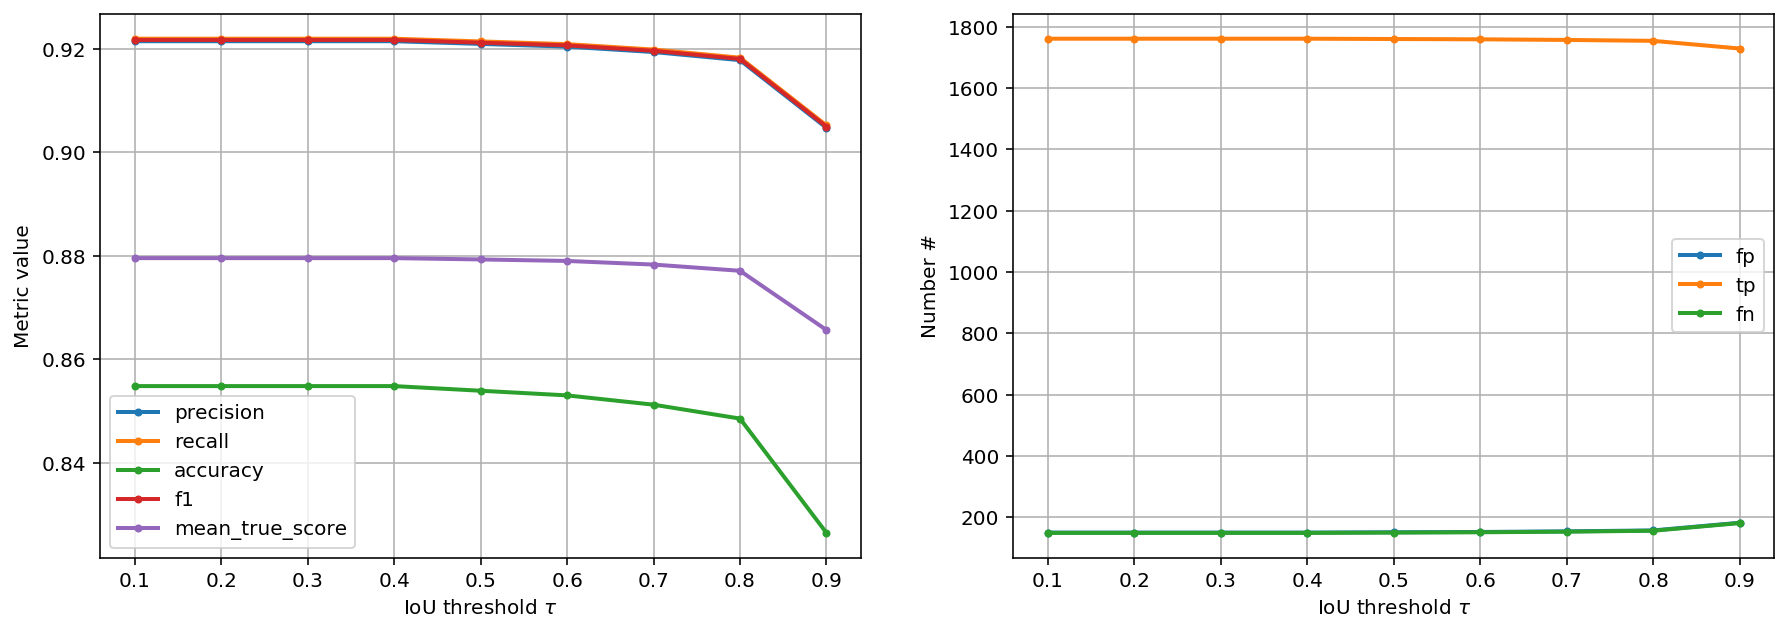

In [14]:
Display_Prediction_Stats = True

if Display_Prediction_Stats:
    Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
                  for x in tqdm(X_val)]
    # Trying several IoU thresholds taus and computing the statistics on the validation data.
    taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score'):
        ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()
    for m in ('fp', 'tp', 'fn'):
        ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();

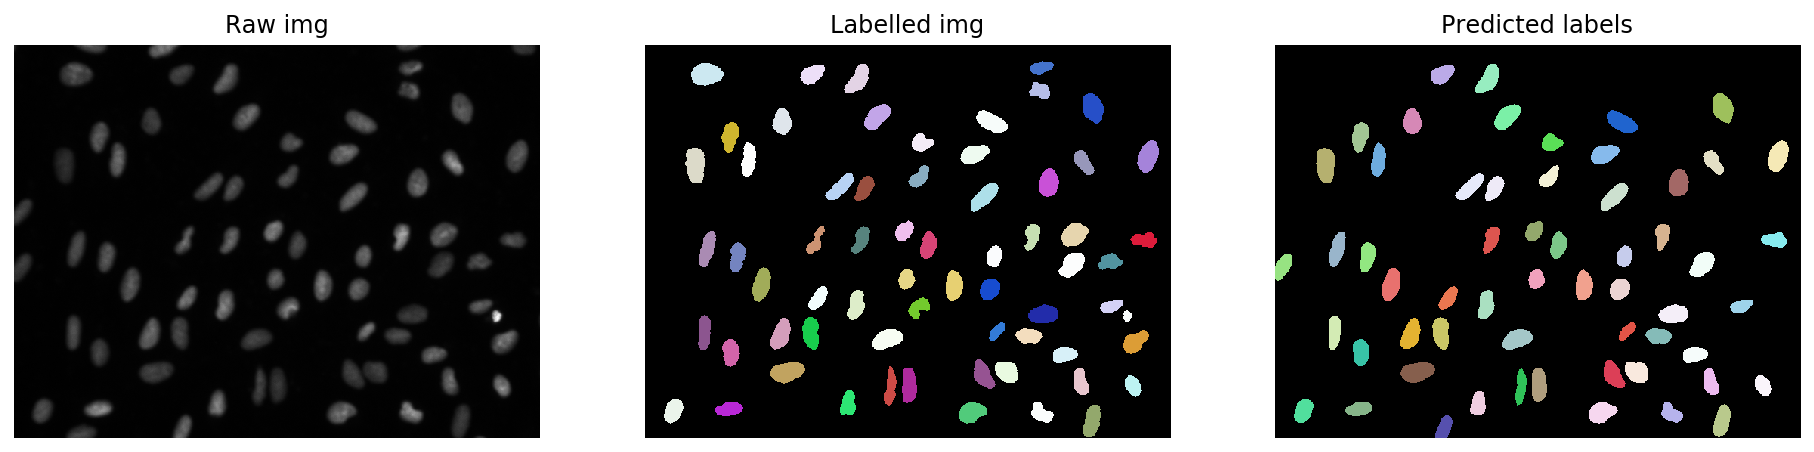

In [15]:
# Example
img=X_val[0]
lbl=Y_val[0]
pred,_ = model.predict_instances(img)

plt.figure(figsize=(16,10))
plt.subplot(1,3,1); plt.imshow(img,cmap='gray', norm=matplotlib.colors.Normalize());   plt.axis('off'); plt.title('Raw img')
plt.subplot(1,3,2); plt.imshow(lbl,cmap=lbl_cmap, norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Labelled img')
plt.subplot(1,3,3); plt.imshow(pred,cmap=lbl_cmap, norm=matplotlib.colors.Normalize()); plt.axis('off'); plt.title('Predicted labels')
plt.savefig(str(os.path.join(MasterPath_MdlTraining,'RetrainedModel.png')))